### Import packages

In [1]:
import os
import glob
import zipfile
import shutil
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
import scipy.stats as stats
import datetime
import pylab as pl
import math
import codecs
import nltk
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import time
import json
import gensim
from gensim import corpora, models
from gensim.matutils import hellinger
from gensim.models.coherencemodel import CoherenceModel
import logging
%matplotlib inline

### Set all important file paths

In [2]:
pwd()

u'/Users/Richard/Desktop/Berkeley/w266/repo/w266_project'

In [3]:
# Richard path specs

# # At work:
# TEXT_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/Text/"
# PDF_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/PDF/"
# LIBRARY_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/Libraries/"

# # At home:
# dict_path = '/Users/Richard/Desktop/Berkeley/w266/'
# input_path = '/Users/Richard/Desktop/Berkeley/w266/repo/w266_project/'
# output_path = '/Users/Richard/Desktop/Berkeley/w266/'

LIBRARY_PATH = '/Users/Richard/Desktop/Berkeley/w266/repo/w266_project/'



In [4]:
# Tom path specs

# Tom machine:
TEXT_DIR_LIST = ["T1", "T2", "T3", "T4"]
# PDF_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/PDF/"
# LIBRARY_PATH = "/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/"

# On Tom's google cloud instance
# LIBRARY_PATH = "/home/seddon/w266_project/"



### Import a dictionary

Import a bag of words style dictionary for word counting analyses


In [5]:
def get_dictionary(file_path, file_name):
    """Read a standard word list dictionary text file into a list"""
    with open(file_path + file_name, "r") as file:
#         words = [word.lower().rstrip('\n') for word in file]
        words = [word.lower().rstrip() for word in file] # had to strip \r as well on my machine
    return words


## Build a list of files that have valid Q&A sections we want to use

This section reviews all the files and rejects any that do not meet our criteria for use.

In [6]:
# Different possible section headers
CO_PART_HEADERS = ['Company Participants']
OTH_PART_HEADERS = ['Other Participants']
MD_SECTION_HEADERS = ['MANAGEMENT DISCUSSION SECTION', 'Presentation']
QA_SECTION_HEADERS = ['Q&A', 'Questions And Answers', 'QUESTION AND ANSWER SECTION',
                      'QUESTION AND ANSWER SESSION', 'QUESTION-AND-ANSWER SECTION']
DISCLAIMER = ['This transcript may not be 100 percent accurate ']


In [7]:

# New text file format has headers
def remove_header_footers(ts):
    i = 0
    header_footer = []
    # Add all the lines before the first 'Page 1 of n' line
    while ts[i].find('Page') == -1:
#         if ts[i].find('Fixed') != -1:
#             print (ts[1], ts[2])
        header_footer.append(ts[i])
        i += 1
    # Extract the total page number and add lines to strip for all the 
    # 'Page x of n' line
    pages = ts[i]
    pages = pages.split(' ')
    page_num = int(pages[-1])
    for i in range(1, page_num + 1):
        header_footer.append('Page ' + str(i) + ' of ' + str(page_num))
    ts = [line for line in ts if line not in header_footer]
    return ts


def read_transcript(file_path):
    # read in all lines of the transcript
    with open(file_path, "r") as file:
        ts = file.readlines()
        ts = [str(unicode(line, errors = 'ignore')) for line in ts]
        ts = [line.rstrip() for line in ts]
        ts = remove_header_footers(ts)
    return ts


# Find the index value of a full string from a list of possible strings
def find_full_string_index(ts, string_list):
    result = -1
    for i in range(len(string_list)):
        if string_list[i] in ts:
            result = ts.index(string_list[i])
    return result

# Find the index of the disclaimer
def find_disclaimer_index(ts, string_list):
    result = -1
    k = len(ts) - 1
    while True:
        for my_str in string_list:
            if ts[k].find(my_str) != -1:
                result = k
                break
        k -= 1
        if k < 0:
            break
    return result

# Get transcript list indices from a single transcript
def get_basic_parameters(ts):
    call_type = ts[0]
    # check call type
    if call_type.find("Earnings Call") == -1:
        call_type = -1
    else:
        if call_type.find("Fixed") != -1:  # don't want Fixed Income calls
            call_type = -1
            
    co_parts = find_full_string_index(ts,CO_PART_HEADERS)
    oth_parts = find_full_string_index(ts,OTH_PART_HEADERS)
    md = find_full_string_index(ts,MD_SECTION_HEADERS)
    qa = find_full_string_index(ts,QA_SECTION_HEADERS)
    disc = find_disclaimer_index(ts,DISCLAIMER)
    return [call_type, co_parts, oth_parts, md, qa, disc]


In [94]:
# Get the file paths to all files of a specified file type from a given directory
def get_files(file_path, file_type):
    file_list = glob.glob(file_path + "*." + file_type)
    return file_list

def get_files_from_dirs(directory_list, file_type):
    # Read in all the files from subdirectories into a master list
    
    matchfiles = []
    for d in directory_list:
        matchfiles.extend(get_files(LIBRARY_PATH+d+"/",'txt'))    
    return matchfiles

def find_valid_files(file_list):
    '''Scans all the files in the file list and returns a list of those which
       pass all QA checks, and a list of those that do not, with reason why'''
    
    good_files = []
    problems = []

    for path in file_list:
        ts = read_transcript(path)
        params = get_basic_parameters(ts)
        
        errs = ["not equity earnings call",
                "no co participants",
                "no other participants",
                "no mgmt discussion section",
                "no Q&A section",
                "no disclaimer"
                ]
        
        errs_found = []
        for i, err in enumerate(errs):
            if params[i] == -1:
                errs_found.append(err)
        
        if len(errs_found) == 0:
            good_files.append(path)
        else:
            problems.append((errs_found, path, params))

    return good_files, problems


files_to_check = get_files_from_dirs(TEXT_DIR_LIST, "txt")
TextFiles, error_files = find_valid_files(files_to_check)

print "Valid Files found: ", len(TextFiles)
print
print "Files rejected:", len(error_files)
print
err_counts = defaultdict(int)
err_lists = defaultdict(list)
for f in error_files:
    for err in f[0]:
        err_counts[err] += 1
        err_lists[err].append(f[1])

print "Number of files with each type of error (file can have >1 error):"
for err in err_counts:
    print err, err_counts[err]
    print "Files are:"
    for f in err_lists[err]:
        print f

Valid Files found:  3245

Files rejected: 103

Number of files with each type of error (file can have >1 error):
no Q&A section 42
Files are:
/Users/Richard/Desktop/Berkeley/w266/repo/w266_project/T1/20100806_1_AIG.txt
/Users/Richard/Desktop/Berkeley/w266/repo/w266_project/T1/20100817_1_WMT.txt
/Users/Richard/Desktop/Berkeley/w266/repo/w266_project/T1/20101105_1_AIG.txt
/Users/Richard/Desktop/Berkeley/w266/repo/w266_project/T1/20101110_1_GM.txt
/Users/Richard/Desktop/Berkeley/w266/repo/w266_project/T1/20101116_1_WMT.txt
/Users/Richard/Desktop/Berkeley/w266/repo/w266_project/T1/20110517_1_WMT.txt
/Users/Richard/Desktop/Berkeley/w266/repo/w266_project/T1/20110816_1_WMT.txt
/Users/Richard/Desktop/Berkeley/w266/repo/w266_project/T1/20111115_1_WMT.txt
/Users/Richard/Desktop/Berkeley/w266/repo/w266_project/T1/20120221_1_WMT.txt
/Users/Richard/Desktop/Berkeley/w266/repo/w266_project/T1/20120517_1_WMT.txt
/Users/Richard/Desktop/Berkeley/w266/repo/w266_project/T1/20120816_1_WMT.txt
/Users/Richa

In [95]:
TextFiles[:5]

['/Users/Richard/Desktop/Berkeley/w266/repo/w266_project/T1/20100730_1_AEP.txt',
 '/Users/Richard/Desktop/Berkeley/w266/repo/w266_project/T1/20100730_1_CVX.txt',
 '/Users/Richard/Desktop/Berkeley/w266/repo/w266_project/T1/20100730_1_MET.txt',
 '/Users/Richard/Desktop/Berkeley/w266/repo/w266_project/T1/20100730_1_MRK.txt',
 '/Users/Richard/Desktop/Berkeley/w266/repo/w266_project/T1/20100730_1_SPG.txt']

### Pre-processing functions

In [100]:
def remove_square_brackets(my_str):
    return re.sub(r'\[.+?\]', '', my_str)

def remove_square_brackets_transcript(ts):
    return list(map(lambda line: remove_square_brackets(line), ts))


In [101]:
# Find participants on the call
def get_parts(ts, start_index, end_index):
    result = [name[re.search("[a-z]", name.lower()).start():] for name in ts[start_index+1:end_index] if len(name) >= 3]
    # Check for problematic names
    extra_names = []
    for name in result:
        # Find any title after name and remove it
        if name.find(',') != -1:
            name_only = name[:name.find(',')]
            extra_names.append(name_only)
        # Find names with middle initials and remove them
        elif name.find('.') != -1:
            name_only = remove_middle_initials(name)
            if name_only != name:
                extra_names.append(name_only)
    # Find names in extra names with middle initials and remove them
    for name in extra_names:
        if name.find('.') != -1:
            name_only = remove_middle_initials(name)
            if name_only != name:
                extra_names.append(name_only)
    return result + extra_names

# Remove middle initial from a name
def remove_middle_initials(my_str):
    # count = 0
    while True:
        if my_str.find('.') != -1:
            new_my_str = re.sub(r'(\s)([A-Z].)(\s)', r"\1", my_str)
            if new_my_str == my_str:
                break
            else:
                my_str = new_my_str
            # count += 1
            # if count >= 10:
            #     break
        else:
            break
    return my_str


In [102]:
# Find a section of the call
def get_section(ts, start_index, end_index):
    result = ts[start_index+1:end_index]
    result = [line for line in result if line not in ['\x0c']]   # clean the transcript for unnecessary lines
    return result


In [103]:
def get_MD(ts, names, start_index, end_index):

    curr_speaker = ""
    section_header = "MD"
    
    # Create an empty dict for comments by each manager
    pts = {name: "" for name in names}

    # Get the required section
    section = get_section(ts, start_index, end_index)
    
    # Find the first instance of a co_parts speaker
    start_section = 0
    while True:
        if section[start_section] not in names:
            start_section += 1
        else:
            break
        if start_section == len(section):
            start_section = -1
            break

    if start_section == -1:
        pts['No speaker found'] = section_header
    else:
        # Reduce MD Section to management speaking only
        section = section[start_section:]
        # populate comment dict
        for line in section:
            if line in names:
                curr_speaker = line
            elif len(line) != 0:
                pts[curr_speaker] += line + " "

    return pts


In [104]:
# This procedure combines the raw Q&A section into pairs of questions and answers in a dictionary

def get_QA(ts, start_index, end_index):

    pts = {}
    # get the Q&A section
    qa_section = get_section(ts, start_index, end_index)

    q_or_a = None
    currQ = ''
    currA = ''
    
    for line in qa_section:
        line = remove_square_brackets(line)
        if len(line) > 0:                                     # if line is '' then ignore otherwise process the line
            if line == 'Operator':                            # if line is 'Operator' then set everything NULL and ignore
                q_or_a = None
                currQ = ''
                currA = ''
            if line[0] == "<":                                # if Q or A found do something
                if line[0:2] == "<Q":
                    if q_or_a == 'A':                         # if Q found and q_or_a is not NULL then add Q: A to the dictionary
                        pts[currQ[:-1]] = currA[:-1]          # and reset the parameters to NULL
                        currQ = ''
                        currA = ''
                        q_or_a = None    
                    end_qa_tag = line.find(">")
                    currQ += line[end_qa_tag + 3:] + " "      # Concatenate the string after the '>' to the previous string
                    q_or_a = 'Q'                              # Given Q found set q_or_a = 'Q'
                if line[0:2] == "<A":
                    end_qa_tag = line.find(">")             
                    currA += line[end_qa_tag + 3:] + " "      # Concatenate the string after the '>' to the previous string
                    q_or_a = 'A'                              # Given Q found set q_or_a = 'Q'
            else:                                             
                if q_or_a is not None:                        # Other if currently a Q or A just concatenate the string 
                    if q_or_a == 'Q':
                        currQ += line + " "
                    else:
                        currA += line + " "

    if currQ != '' and currA != '':                           # Add last Q: A pair to the dictionary if necessary
        pts[currQ[:-1]] = currA[:-1]

    return pts




### Bespoke cleaning

The following procedures deal with strings with words that have apostrophes, hyphens, slashes and unusual characters in them to help best isolate actual words.

In [105]:
def short_form_replace(my_str):
    """Convert apostrophes in known short-forms in my_string to long-forms"""
    my_str = replace_non_utf8_apostrophes(my_str)
    my_str = re.sub(r'let\'s', "let us", my_str)
    my_str = re.sub(r'Let\'s', "let us", my_str)
    my_str = re.sub(r'won\'t', "will not", my_str)
    my_str = re.sub(r'can\'t', "cannot", my_str)
    my_str = re.sub(r'shan\'t', "shall not", my_str)
    my_str = re.sub(r'Won\'t', "Will not", my_str)
    my_str = re.sub(r'Can\'t', "Cannot", my_str)
    my_str = re.sub(r'Shan\'t', "Shall not", my_str)
    my_str = re.sub(r'n\'t', " not", my_str)
    my_str = re.sub(r'\'ve', " have", my_str)
    my_str = re.sub(r'\'re', " are", my_str)
    my_str = re.sub(r'\'m', " am", my_str)
    my_str = re.sub(r'\'ll', " will", my_str)
    my_str = re.sub(r'\'d', " would", my_str)     # note could also be did or had as well
    my_str = re.sub(r'it\'s', "it is", my_str)
    my_str = re.sub(r'he\'s', "he is", my_str)
    my_str = re.sub(r'she\'s', "she is", my_str)
    my_str = re.sub(r'that\'s', "that is", my_str)
    my_str = re.sub(r'what\'s', "what is", my_str)
    my_str = re.sub(r'here\'s', "here is", my_str)
    my_str = re.sub(r'there\'s', "there is", my_str)
    my_str = re.sub(r'who\'s', "who is", my_str)
    my_str = re.sub(r'It\'s', "It is", my_str)
    my_str = re.sub(r'He\'s', "He is", my_str)
    my_str = re.sub(r'She\'s', "She is", my_str)
    my_str = re.sub(r'Shat\'s', "That is", my_str)
    my_str = re.sub(r'What\'s', "What is", my_str)
    my_str = re.sub(r'Here\'s', "Here is", my_str)
    my_str = re.sub(r'There\'s', "There is", my_str)
    my_str = re.sub(r"Who's", "Who is", my_str)
    return my_str


def apostrophe_s_replace(my_str):
    """Remove 's at the end of words in my_string. Best to run this after short_form_replace()"""
    my_str = re.sub(r"([A-z])\'s", r"\1", my_str)
    return my_str


def hyphen_replace(my_str):
    """Replace hyphens in hyphenated words with a space"""
    my_str = re.sub(r"([A-z])(\-)([A-z])", r"\1 \3", my_str)
    my_str = re.sub(r"([A-z])(\-)(\s)([A-z])", r"\1 \4", my_str)
    return my_str


def forward_slash_replace(my_str):
    """Replace forward slashes in combined words with a space."""
    my_str = re.sub(r"([A-z])(/)([A-z])", r"\1 \3", my_str)
    my_str = my_str.replace(')/', ' ')
    my_str = my_str.replace('/(', ' ')
    return my_str


def replace_apostrophes(my_str):
    """Tidy up my_string for all apostrophe-related issues."""
    my_str = replace_non_utf8_apostrophes(my_str)
    my_str = short_form_replace(my_str)
    my_str = apostrophe_s_replace(my_str)
    return my_str


def clean_text(my_str):
    """Clean my_string for all known string issues to prepare for text analysis"""
    my_str = replace_apostrophes(my_str)
    my_str = hyphen_replace(my_str)
    my_str = forward_slash_replace(my_str)
    return my_str


def replace_non_utf8_apostrophes(my_str):
    """Replace most common non-utf-8 apostrophes with utf-8 apostrophes"""
    apostrophes = [str(b'\xe2\x80\x98'), str(b'\xe2\x80\x99')]
    for i in range(len(my_str)):
        if str(my_str[i].encode('utf-8')) in apostrophes:
            my_str = my_str[:i] + "'" + my_str[i+1:]
    return my_str



#### Example

### Tokenization

In [106]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

### Stop Words

In [107]:
# Import stop words list
stop_words = get_dictionary(LIBRARY_PATH,'stop_words.txt')

In [108]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Richard/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [109]:
from nltk.corpus import stopwords

In [110]:
# Create English stop words list from NLTK
nltk_stop_words = stopwords.words('english')

In [111]:
stop_words = sorted(list(set(stop_words + nltk_stop_words)))

### Stemming

In [112]:
from nltk.stem.porter import PorterStemmer

### Vectorize the word list counts


In [113]:
def vectorize_word_list_counts(words, word_list):
    """Count the frequency of words in a document from a word list"""
    count_vector = [words.count(word) for word in sorted(word_list)]
    total_count = sum(count_vector)
    if total_count != 0:
        count_vector = [float(count)/total_count for count in count_vector]
    return count_vector


## Baseline Model 1: Scriptedness

Essentially **Scriptedness** attempts to measure the degree to which answers given by management have been scripted by the same person that scripted the Management Discussion section (most likely the Investor Relations person). In linguistics function word usage is the best indicator of whether two written pieces have been written by the same person. So to test for this we calculate the cosine similarity of function word usage in the MD and Q&A sections. 

### Scriptedness pre-processing a document

In [114]:
def stemmer(tokens, word_stemmer):
    try:
        stemmed_tokens = [word_stemmer.stem(i) for i in tokens]
    except:
        stemmed_tokens = []
        for i in tokens:
            try:
                stemmed_tokens.append(word_stemmer.stem(i))
            except:
                pass
        if len(stemmed_tokens) == 0:
            stemmed_tokens = tokens
    return stemmed_tokens


def scriptedness_pre_process_document(doc):
    tokenizer = RegexpTokenizer(r'\w+')  # This finds letters only and breaks things up at each non-letters character
    porter_stemmer = PorterStemmer()
    lower_doc = doc.lower()
    clean_lower_doc = remove_square_brackets(lower_doc)
    clean_doc = clean_text(clean_lower_doc)
    tokens = tokenizer.tokenize(clean_doc)
    stopped_tokens = tokens # no stopping
    stemmed_tokens = stemmer(stopped_tokens, porter_stemmer)
    count_vector = vectorize_word_list_counts(stemmed_tokens, function_words)
    return count_vector

### Scriptedness makes use of Cosine Similarity

In [115]:
def cosine_similarity(v1, v2):
    """Returns the cosine similarity score for two equal length vectors of numbers.
    To compute cosine similarity of v1 to v2: (v1 dot v2)/{||v1||*||v2||)."""
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x, y = v1[i], v2[i]
        sumxx += x * x
        sumyy += y * y
        sumxy += x * y
    if math.sqrt(sumxx * sumyy) !=0:
        result = round(sumxy/math.sqrt(sumxx * sumyy),6)
    else:
        result = 0
    return result


In [116]:
# This gets the average similarity for one comment, i.e. full MD section, and all the answers separately
def get_avg_score(comment, answers):
    scores = []
    v1 = comment
    for v2 in answers:
        scores.append(cosine_similarity(v1, v2))
    avg_score = round(sum(scores)/len(scores),6)
    return avg_score


In [98]:
def get_filename_components(file_path, i):
    file_name_and_ext = os.path.basename(file_path)
    name_only = os.path.splitext(file_name_and_ext)[0]
    date, file_num, ticker = name_only.split("_")
    
#     file_path = file_path.split('_')
#     print (i, file_path)
#     date = file_path[0][-8:]
#     file_num = file_path[1]
#     ticker = file_path[2][:-4]
    return (ticker, date, file_num)
    

## Read in the raw files so they can be processed in different ways

In [117]:
raw_files = {}
i = 0
report_every = 100
start_time = time.time()

for f in TextFiles[:]:
    
    (ticker, date, file_num) = get_filename_components(f, i)

    ts = read_transcript(f)
    
    raw_files[f] = ((ticker, date, file_num), ts)
    
    i += 1
    if i % report_every == 0:
        print "Processed ", i, "in ", time.time() - start_time, "seconds"
    


Processed  100 in  0.162449121475 seconds
Processed  200 in  0.320029020309 seconds
Processed  300 in  0.472424030304 seconds
Processed  400 in  0.617825984955 seconds
Processed  500 in  0.769307136536 seconds
Processed  600 in  0.930818080902 seconds
Processed  700 in  1.0838971138 seconds
Processed  800 in  1.23683404922 seconds
Processed  900 in  1.40172314644 seconds
Processed  1000 in  1.55250501633 seconds
Processed  1100 in  1.71003508568 seconds
Processed  1200 in  1.8656680584 seconds
Processed  1300 in  2.02167606354 seconds
Processed  1400 in  2.17156004906 seconds
Processed  1500 in  2.39148616791 seconds
Processed  1600 in  2.55667495728 seconds
Processed  1700 in  2.70704603195 seconds
Processed  1800 in  2.84685015678 seconds
Processed  1900 in  3.00948095322 seconds
Processed  2000 in  3.2273709774 seconds
Processed  2100 in  3.39713215828 seconds
Processed  2200 in  3.56429004669 seconds
Processed  2300 in  3.69199705124 seconds
Processed  2400 in  3.84757709503 second

### Perform Scriptedness Analysis

In [27]:
a = 3
b = 6
print b % a

0


In [28]:
function_words = get_dictionary(LIBRARY_PATH,'function_words.txt')

results = {}
i = 0
report_every = 100
start_time = time.time()

for f in TextFiles[:]:
    
    (ticker, date, file_num) = get_filename_components(f, i)

    ts = read_transcript(f)
    
    if 'Earnings Call' in ts[0]:
        # Get Company Participants
        start = find_full_string_index(ts, CO_PART_HEADERS)
        end = find_full_string_index(ts, OTH_PART_HEADERS) - 1
        if start != -1 and end != -2: 
            co_part_names = get_parts(ts, start, end)

            # Get MD Section
            start = find_full_string_index(ts, MD_SECTION_HEADERS)
            end = find_full_string_index(ts, QA_SECTION_HEADERS) - 1
            MD = get_MD(ts, co_part_names, start, end)
            comments = [comment for comment in MD.values() if len(comment) > 20]
            comment = ' '.join(comments)
            comment = scriptedness_pre_process_document(comment)

            # Get QA Section
            start = find_full_string_index(ts, QA_SECTION_HEADERS)
            end = find_disclaimer_index(ts, DISCLAIMER)
            QA = get_QA(ts, start, end)    
            # get the answers with a condition to ensure the answer is of at least some length
            answers = [answer for answer in QA.values() if len(answer) > 20]
            answers = [scriptedness_pre_process_document(answer) for answer in answers]
            
            

            if date not in results.keys():
                results[date] = {}

            if len(answers) > 0:
                results[date][ticker] = get_avg_score(comment, answers)
        i += 1
        if i % report_every == 0:
            print "Processed ", i, "in ", time.time() - start_time, "seconds"
            
            

Processed  100 in  33.5548188686 seconds
Processed  200 in  68.3045790195 seconds
Processed  300 in  100.145046949 seconds
Processed  400 in  134.703547001 seconds
Processed  500 in  168.39257884 seconds
Processed  600 in  204.255578995 seconds
Processed  700 in  234.912051916 seconds
Processed  800 in  267.975925922 seconds
Processed  900 in  302.698899984 seconds
Processed  1000 in  337.837255955 seconds
Processed  1100 in  370.57354784 seconds
Processed  1200 in  402.978616953 seconds
Processed  1300 in  435.89755106 seconds
Processed  1400 in  464.949396849 seconds
Processed  1500 in  499.311426878 seconds
Processed  1600 in  532.417566061 seconds
Processed  1700 in  564.614953995 seconds
Processed  1800 in  596.978741884 seconds
Processed  1900 in  629.476178885 seconds
Processed  2000 in  664.991369009 seconds
Processed  2100 in  697.727658987 seconds
Processed  2200 in  730.144827843 seconds
Processed  2300 in  761.838392973 seconds
Processed  2400 in  795.078687906 seconds
Proc

In [29]:
results

{'20100730': {'AEP': 0.700156,
  'CVX': 0.58198,
  'MET': 0.59171,
  'MRK': 0.747433,
  'SPG': 0.60501,
  'WY': 0.532411},
 '20100803': {'BHI': 0.629955,
  'DOW': 0.65646,
  'DUK': 0.578824,
  'EMR': 0.519417,
  'ETR': 0.600502,
  'MA': 0.614056,
  'NYX': 0.51326,
  'PCLN': 0.656028,
  'PFE': 0.360584,
  'PG': 0.336925},
 '20100804': {'CHTR': 0.671091,
  'DVN': 0.625642,
  'FOXA': 0.523457,
  'TWX': 0.739454},
 '20100805': {'AGN': 0.60002, 'ALL': 0.510867, 'MDLZ': 0.590864},
 '20100810': {'DIS': 0.72788},
 '20100811': {'CSCO': 0.455655},
 '20100812': {'GM': 0.56016, 'HSH': 0.576464},
 '20100816': {'LOW': 0.637366},
 '20100817': {'HD': 0.663928},
 '20100818': {'TGT': 0.744857},
 '20100819': {'DELL': 0.63952, 'HPQ': 0.705189},
 '20100824': {'MDT': 0.673229},
 '20100901': {'HNZ': 0.577725},
 '20100903': {'CPB': 0.460749},
 '20100916': {'FDX': 0.72698, 'ORCL': 0.712935},
 '20100923': {'NKE': 0.583516},
 '20100928': {'WBA': 0.621681},
 '20100930': {'ACN': 0.597531, 'NEE': 0.496709},
 '20101

In [30]:
with open("cosine_sim_results_1209.txt", "w") as f:
    f.write(json.dumps(results))

In [8]:
with open("cosine_sim_results_1209.txt", "r") as f:
    results_back = json.loads(f.read())

In [9]:
results_back

{u'20100730': {u'AEP': 0.700156,
  u'CVX': 0.58198,
  u'MET': 0.59171,
  u'MRK': 0.747433,
  u'SPG': 0.60501,
  u'WY': 0.532411},
 u'20100803': {u'BHI': 0.629955,
  u'DOW': 0.65646,
  u'DUK': 0.578824,
  u'EMR': 0.519417,
  u'ETR': 0.600502,
  u'MA': 0.614056,
  u'NYX': 0.51326,
  u'PCLN': 0.656028,
  u'PFE': 0.360584,
  u'PG': 0.336925},
 u'20100804': {u'CHTR': 0.671091,
  u'DVN': 0.625642,
  u'FOXA': 0.523457,
  u'TWX': 0.739454},
 u'20100805': {u'AGN': 0.60002, u'ALL': 0.510867, u'MDLZ': 0.590864},
 u'20100810': {u'DIS': 0.72788},
 u'20100811': {u'CSCO': 0.455655},
 u'20100812': {u'GM': 0.56016, u'HSH': 0.576464},
 u'20100816': {u'LOW': 0.637366},
 u'20100817': {u'HD': 0.663928},
 u'20100818': {u'TGT': 0.744857},
 u'20100819': {u'DELL': 0.63952, u'HPQ': 0.705189},
 u'20100824': {u'MDT': 0.673229},
 u'20100901': {u'HNZ': 0.577725},
 u'20100903': {u'CPB': 0.460749},
 u'20100916': {u'FDX': 0.72698, u'ORCL': 0.712935},
 u'20100923': {u'NKE': 0.583516},
 u'20100928': {u'WBA': 0.621681},


### Calculate Portfolio Returns for Scriptedness

In [17]:
# process to read in returns into a dictionary: {month_end: {code: (return, market_cap)}}
def get_returns(myFilename):
    returns = {}
    with open(myFilename) as f:
        for line in f:
            code, date, rtn, mcap = line.rstrip('\n').rstrip('\r').split(',')
            if date != 'MthEnd':
                month_end = date[-4:] + date[3:5]
                if month_end not in returns.keys():
                    returns[month_end] = {}
                if rtn != 'NA':
                    rtn = float(rtn)/100
                if mcap != 'NA':
                    mcap = float(mcap)
                returns[month_end][code] = (rtn, mcap)
    return returns


def calculate_benchmark_returns(returns):
    benchmarks = {}
    for date, stocks in returns.items():
        ew_return_sum = 0
        mc_return_sum = 0
        num_stocks = 0
        total_cap = 0
        for code, stock_details in stocks.items():
            rtn, mcap = stock_details
            if rtn != 'NA':
                ew_return_sum += rtn
                num_stocks += 1
            if rtn != 'NA' and mcap != 'NA':
                mc_return_sum += rtn * mcap
                total_cap += mcap

            benchmarks[date] = (ew_return_sum / num_stocks, mc_return_sum / total_cap)

    return benchmarks


# This process converts scores from daily to month end
# It also considers if a score has been updated or not in the month.
# If NOT updated it retains the score from the previous month and increases its age or staleness by 1 month

def collate_month_end_scores(scores):

    # get all daily days - importantly in sorted chronological order oldest to newest
    dates = sorted(scores.keys())
    # get all month end dates from the daily dates
    m_list = sorted(list(set([date[:6] for date in dates])))

    # Note:  There can be months where we have no transcripts.  To make the
    # code later in the function work for that situation, we first identify
    # any missing months, then put in an empty scores dictionary for the
    # first day of that month.

    month_ends = []
    first = int(m_list[0])
    last = int(m_list[-1])
    first_yr = int(m_list[0][:4])
    last_yr = int(m_list[-1][:4])

    for y in range(first_yr, last_yr+1):
        for m in range(1, 13):
            if (y*100+m >= first and y*100+m <= last):
                month_ends.append("{:4d}{:02d}".format(y, m))

    # identify months where there are no transcripts
    missing_months = [m for m in month_ends if m not in m_list]
    for m in missing_months:
        scores[m+"01"] = {}
    # update date list to include any missing months added
    dates = sorted(scores.keys())

    # get all stocks in our coverage universe
    codes = []
    for date in dates:
        for code in scores[date].keys():
            if code not in codes:
                codes.append(code)
    # set the current month end to None to start the process
    curr_month_end = None
    # create an empty list to house the month end scores
    monthly_scores = {}

    # pass through the scores in chronological order
    for date in dates:

        # collect the month end for the current date
        month_end = date[:6]

        # if found a new month end
        if month_end != curr_month_end:

            # add a new month end dictionary for the monthly scores dictionary
            monthly_scores[month_end] = {}

            # check if there is a past month
            # if no past month populate the empty dictionary for scores on the given date, i.e. first entry
            if len(monthly_scores.keys()) < 2:
                for code, score in scores[date].items():
                    monthly_scores[month_end][code] = (score, 1) # note including a score age parameter

            # otherwise if a past month exists add missing codes for the month either as NA or the previous month value
            else:

                # check if there is a previous month to grab scores from
                prev_month_end_idx = month_ends.index(curr_month_end) - 1

                # there is a previous month
                if prev_month_end_idx >= 0:
                    # collect previous month end
                    prev_month_end = month_ends[prev_month_end_idx]
                    # iterate through codes to find ones not in the current month end dictionary
                    for code in codes:
                        if code not in monthly_scores[curr_month_end].keys():
                            if code in monthly_scores[prev_month_end].keys():
                                # there is no previous score
                                if monthly_scores[prev_month_end][code][0] == 'NA':
                                    monthly_scores[curr_month_end][code] = ('NA', 0)
                                # there is a previous score
                                else:
                                    # get the previous score and increment age by one month
                                    (prev_score, age) = monthly_scores[prev_month_end][code]
                                    monthly_scores[curr_month_end][code] = (prev_score, age + 1)

                # there is not a previous month
                else:
                    # populate missing codes as 'NA'
                    for code in codes:
                        if code not in monthly_scores[curr_month_end].keys():
                            monthly_scores[curr_month_end][code] = ('NA', 0)

            # update the current month end parameter
            curr_month_end = month_end

        # haven't found a new month
        else:
            for code, score in scores[date].items():
                monthly_scores[month_end][code] = (score, 1) # note including a score age parameter

    return monthly_scores


# process to calculate the percentile of each of the scores subject to a maximum age of the score
def get_percentile_scores(scores, max_age):
    percentiles = []
    numeric_scores = [score for (score, age) in scores.values() if score != 'NA' and age <= max_age]
    for code in sorted(scores.keys()):
        score, age = scores[code]
        if score == 'NA' or age > max_age:
            percentiles.append('NA')
        else:
            percentiles.append(stats.percentileofscore(numeric_scores, score))
    return percentiles

def convert_to_portfolio_int(percentile, num_portfolios):
    num = num_portfolios * percentile / 100
    if num < 0:
        return 0
    elif num >= num_portfolios:
        return num_portfolios - 1
    else:
        return int(num)

def create_fractile_portfolios(scores, num_portfolios, max_age):
    percentiles = get_percentile_scores(scores, max_age)
    # populate holdings dictionary for selected number of portfolios
    holdings = {i:[] for i in range(0,num_portfolios)}
    holdings['NA'] = []
    for code, percentile in zip(sorted(scores.keys()), percentiles):
        if percentile == 'NA':
            holdings['NA'].append(code)
        else:
            port_num = convert_to_portfolio_int(percentile, num_portfolios)
            holdings[port_num].append(code)
    return holdings


def average_return(returns, benchmark):
    if len(returns) == 0:
        average_alpha = 0
    else:
        average_alpha = sum(returns)/len(returns) - benchmark
    return (average_alpha, len(returns))

def calculate_portfolio_returns(portfolios, returns, benchmark, bm_type=0):
    portfolio_returns = {portfolio:[] for portfolio in portfolios.keys()}
    for portfolio, stocks in portfolios.items():
        if portfolio != 'NA':
            for stock in stocks:
                if stock in returns.keys():
                    if returns[stock][0] != 'NA':
                        portfolio_returns[portfolio].append(returns[stock][0])
        else:
            for stock in stocks:
                portfolio_returns['NA'].append(benchmark[bm_type])

    portfolio_returns = {pf:average_return(rets, benchmark[bm_type]) for pf, rets in portfolio_returns.items()}

    return portfolio_returns


# This process produces a time series of monthly portfolio returns by iterating through the whole scores dictionary
def portfolio_return_time_series(scores, returns, benchmarks, num_portfolios, max_age=4):
    monthly_portfolios = {}
    portfolio_return_time_series = {}

    # get key dates
    dates = sorted(scores.keys())                                 # important in chronological order
    month_ends = sorted(list(set([date[:6] for date in dates])))  # important in chronological order

    for month_end in month_ends[1:-1]:
        monthly_portfolios[month_end] = create_fractile_portfolios(scores[month_end], num_portfolios, max_age)
        portfolio_return_time_series[month_end] = calculate_portfolio_returns(monthly_portfolios[month_end], returns[month_end], benchmarks[month_end])
    return portfolio_return_time_series


def calculate_cumulative_alpha(time_series, dates):
    port_nums = [num for num in time_series[list(time_series.keys())[0]].keys() if num != 'NA']
    cumulative_portfolios = {i:[] for i in port_nums}
    cumulative_alphas = []
    for date in dates:
        return_series = time_series[date]
        for port_num in port_nums:
            cumulative_portfolios[port_num].append(return_series[port_num][0])
    for portfolio in sorted(cumulative_portfolios.keys()):
        cumulative_alphas.append([sum(cumulative_portfolios[portfolio][:i]) for i in range(len(cumulative_portfolios[portfolio]))])
    return cumulative_alphas


def calculate_portfolio_holding_numbers(time_series, dates):
    port_nums = [num for num in time_series[list(time_series.keys())[0]].keys() if num != 'NA']
    portfolio_holdings = {i:[] for i in port_nums}
    holdings = []
    for date in dates:
        return_series = time_series[date]
        for port_num in port_nums:
            portfolio_holdings[port_num].append(return_series[port_num][1])
    for portfolio in sorted(portfolio_holdings.keys()):
        holdings.append(portfolio_holdings[portfolio])
    return holdings


def convert_YYYYMM(date):
    year = int(date[:4])
    month = int(date[4:])
    day = 1
    return datetime.datetime(year=year, month=month, day=day)

def print_time_series(time_series, dates):
    dates = [convert_YYYYMM(date) for date in dates]
    for i in range(len(time_series)):
        series = time_series[i]
        series_label = 'P' + str(i+1)
        if i == 0:
            pl.plot(dates, series, label=series_label, color='black')
        else:
            pl.plot(dates, series, label=series_label)
    pl.legend(loc=0)
    pl.show()


def produce_portfolio_results(scores, LIBRARY_PATH, num_portfolios, max_age=4):

    # Get returns
    returns = get_returns(LIBRARY_PATH + 'returns_data.csv')

    # Calculate the benchmark returns
    benchmarks = calculate_benchmark_returns(returns)

    # Collate the month end scores from the daily score data
    monthly_scores = collate_month_end_scores(scores)
    
    # Get all daily dates from score and convert to month ends
    dates = sorted(scores.keys())                                 # important in chronological order
    month_ends = sorted(list(set([date[:6] for date in dates])))  # important in chronological order

    # Create month end portfolios
    monthly_portfolios = {}
    for month_end in month_ends:
        monthly_portfolios[month_end] = create_fractile_portfolios(monthly_scores[month_end], num_portfolios, max_age)

    # Calculate monthly returns time series
    monthly_returns_time_series = portfolio_return_time_series(monthly_scores, returns, benchmarks, num_portfolios)

    # Calculate cumulative alpha and portfolio holding numbers time series
    month_ends = sorted(returns.keys())                           # important in chronological order
    cumulative_alphas = calculate_cumulative_alpha(monthly_returns_time_series, month_ends)
    holdings = calculate_portfolio_holding_numbers(monthly_returns_time_series, month_ends)

    # Print cumulative alpha and portfolio holding numbers
    print_time_series(cumulative_alphas, month_ends)
    print_time_series(holdings, month_ends)
    
    return collate_month_end_scores(scores)
    

def convert_monthly_scores_to_changes(monthly_scores):

    m_scores_dates = sorted(monthly_scores.keys())

    # get all stocks in our coverage universe
    codes = []
    for date in m_scores_dates:
        for code in monthly_scores[date].keys():
            if code not in codes:
                codes.append(code)

   # Create an empty dict for the changes of scores
    changes = {date: {} for date in m_scores_dates[2:]}

    # Add changes for the third month in the data series as ('NA',0)
    for ticker in codes:
        changes[m_scores_dates[2]][ticker] = ('NA',0)

    # Iterate through the dates
    for i in range(3,len(m_scores_dates)):

        #  Get current date and previous date
        curr_date = m_scores_dates[i]
        prev_date = m_scores_dates[i-1]

        for ticker in monthly_scores[curr_date]:

            # get score information
            curr_score, curr_score_age = monthly_scores[curr_date][ticker]
            prev_score, prev_score_age = monthly_scores[prev_date][ticker]
            prev_change, prev_change_age = changes[prev_date][ticker]

            if curr_score == 'NA': # still no absolute score found

                changes[curr_date][ticker] = ('NA',0)

            else:

                # A change has not been found and still has not
                if prev_change == 'NA' and (prev_score == 'NA' or curr_score == prev_score): 
                    changes[curr_date][ticker] = ('NA',0)         

                # A change has not been found, but has now
                elif prev_change == 'NA' and curr_score != prev_score:
                    changes[curr_date][ticker] = (curr_score-prev_score,1)         

                # A change has not been found, but no further update this month
                elif prev_change != 'NA' and curr_score == prev_score: 
                    changes[curr_date][ticker] = (prev_change, prev_change_age + 1)

                # A change has been found and there is an update this month
                elif prev_change != 'NA' and curr_score != prev_score: 
                    changes[curr_date][ticker] = (curr_score - prev_score, 1)
 
    return changes


def produce_portfolio_changes_results(changes, LIBRARY_PATH, num_portfolios, max_age=4):

    # Get returns
    returns = get_returns(LIBRARY_PATH + 'returns_data.csv')

    # Calculate the benchmark returns
    benchmarks = calculate_benchmark_returns(returns)

    month_ends = sorted(changes.keys())  # important in chronological order

    # Create month end portfolios
    monthly_portfolios = {}
    for month_end in month_ends:
        monthly_portfolios[month_end] = create_fractile_portfolios(changes[month_end], num_portfolios, max_age)

    # Calculate monthly returns time series
    monthly_returns_time_series = portfolio_return_time_series(changes, returns, benchmarks, num_portfolios)

    # Calculate cumulative alpha and portfolio holding numbers time series
    month_ends = sorted(returns.keys())[6:]                           # important in chronological order
    cumulative_alphas = calculate_cumulative_alpha(monthly_returns_time_series, month_ends)
    holdings = calculate_portfolio_holding_numbers(monthly_returns_time_series, month_ends)

    # Print cumulative alpha and portfolio holding numbers
    print_time_series(cumulative_alphas, month_ends)
    print_time_series(holdings, month_ends)
    

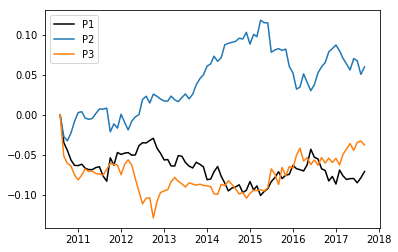

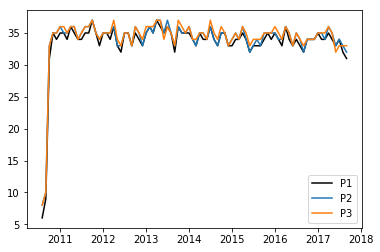

In [18]:
monthly_scores = produce_portfolio_results(results_back, LIBRARY_PATH, 3, max_age=4)

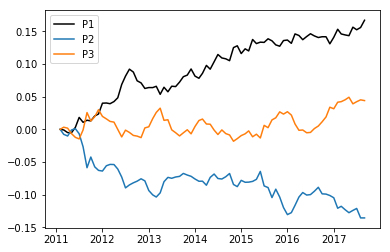

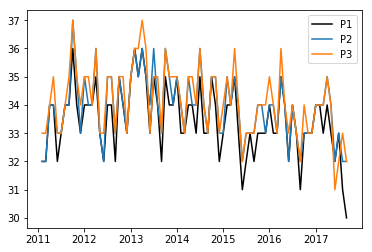

In [19]:
changes = convert_monthly_scores_to_changes(monthly_scores)
produce_portfolio_changes_results(changes, LIBRARY_PATH, 3, max_age=4)



In [58]:
# confirm order of percentileofscore
numeric_scores = [0.01,.3,.4,.44,.56,.6,.65,.5,.2,.4,.8,.99]
for score in numeric_scores:
    print score, stats.percentileofscore(numeric_scores, score)

0.01 8.33333333333
0.3 25.0
0.4 37.5
0.44 50.0
0.56 66.6666666667
0.6 75.0
0.65 83.3333333333
0.5 58.3333333333
0.2 16.6666666667
0.4 37.5
0.8 91.6666666667
0.99 100.0


Mean sim score is 0.607857327524
SD of sim scores is 0.155181479641


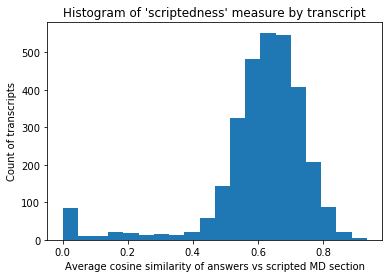

In [36]:
# Simple analysis and distribution plot for similarities

# Just build a vector of similarity scores
sim_scores = []
for day_record in results:
    for co_id in results[day_record]:
        sim_scores.append(results[day_record][co_id])
        
print "Mean sim score is", np.mean(sim_scores)
print "SD of sim scores is", np.std(sim_scores)

plt.hist(sim_scores, bins = 20)
plt.xlabel("Average cosine similarity of answers vs scripted MD section")
plt.ylabel("Count of transcripts")
plt.title("Histogram of 'scriptedness' measure by transcript")

Mean sim score is -0.00224757794353
SD of sim scores is 0.142899715847


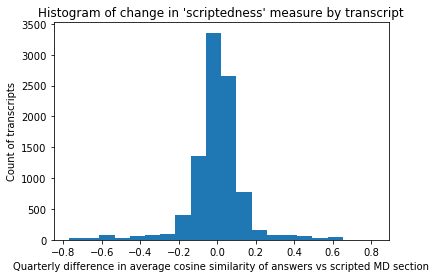

In [62]:
# Simple analysis and distribution plot for changes in similarities

# Just build a vector of similarity scores
sim_scores = []
for date in changes.keys():
    for ticker in changes[date].keys():
        if changes[date][ticker][0] != 'NA':
            sim_scores.append(changes[date][ticker][0])
        
print "Mean sim score is", np.mean(sim_scores)
print "SD of sim scores is", np.std(sim_scores)

plt.hist(sim_scores, bins = 20)
plt.xlabel("Quarterly difference in average cosine similarity of answers vs scripted MD section")
plt.ylabel("Count of transcripts")
plt.title("Histogram of change in 'scriptedness' measure by transcript")

## Baseline Model 2: Repeatedness

An alternate measure of possible evasiveness is **repeatedness**, i.e. how much do management just repeat in their answers exactly what they said in the Management Discussion section. The more they stick to the script or repeat what was previously said the more likely they are trying to evade drifting to more natural language discussion.

We test this in two ways:

(1) The similarity of unique words that are used in the answers and the MD section.

(2) The propotionate overlap of n-grams between the answers and the MD section.

### Repeatedness: Model 1 Uniqueness

### Uniqueness pre-processing a document

In [37]:
# Receives a count_vector dictionary and returns a list of the unique words, i.e. only appear once
def get_unique_words(count_vector):
    unique_words = [key for key in count_vector.keys() if count_vector[key] == 1]
    return unique_words


In [38]:
# Get raw word counts from a document into a dictionary
def vectorize_word_count(words):
    """Count the frequency of words in a document"""
    count_vector = {word: words.count(word) for word in words}
    return count_vector


In [39]:
def uniqueness_pre_process_document(doc):
    tokenizer = RegexpTokenizer(r'\w+')  # This finds letters only and breaks things up at each non-letters character
    porter_stemmer = PorterStemmer()
    lower_doc = doc.lower()
    clean_lower_doc = remove_square_brackets(lower_doc)
    clean_doc = clean_text(clean_lower_doc)
    tokens = tokenizer.tokenize(clean_doc)
    stopped_tokens = [word for word in tokens if word not in stop_words]
    stemmed_tokens = [porter_stemmer.stem(i) for i in stopped_tokens]
    count_vector = vectorize_word_count(stemmed_tokens)
    unique_words = get_unique_words(count_vector)
    return unique_words


### Perform Uniqueness Analysis

In [40]:
b2_results = {}
raw_files = {}
i = 0
report_every = 100
start_time = time.time()

for f in TextFiles[:]:
    
    (ticker, date, file_num) = get_filename_components(f, i)

    ts = read_transcript(f)
    
    raw_files[f] = ((ticker, date, file_num), ts)
    
    if 'Earnings Call' in ts[0]:
        
        # Get Company Participants
        start = find_full_string_index(ts, CO_PART_HEADERS)
        end = find_full_string_index(ts, OTH_PART_HEADERS) - 1
        
        if start != -1 and end != -2: 
            co_part_names = get_parts(ts, start, end)

            # Get MD Section
            start = find_full_string_index(ts, MD_SECTION_HEADERS)
            end = find_full_string_index(ts, QA_SECTION_HEADERS) - 1
            MD = get_MD(ts, co_part_names, start, end)
            comments = [comment for comment in MD.values() if len(comment) > 20]
            comment = ' '.join(comments)
            
            # Pre-process and convert to a list of unique words
            comment = uniqueness_pre_process_document(comment)
            
            # Get QA Section
            start = find_full_string_index(ts, QA_SECTION_HEADERS)
            end = find_disclaimer_index(ts, DISCLAIMER)
            QA = get_QA(ts, start, end)    
            # get the answers with a condition to ensure the answer is of at least some length
            answers = [answer for answer in QA.values() if len(answer) > 20]
            # convert to a list of unique word lists
            answers = [uniqueness_pre_process_document(answer) for answer in answers]
            
            # get all the unique words from the MD and QA sections into one list of unique words
            all_words = [word for word in comment]
            for answer in answers:
                for word in answer:
                    if word not in all_words:
                        all_words.append(word)

            # sort them
            all_words = sorted(all_words)
            
            # binarize the MD and Q&A word lists
            comment_vect = [1 if word in comment else 0 for word in all_words] 
            answers_vect = [[1 if word in answer else 0 for word in all_words] for answer in answers]

            if date not in b2_results.keys():
                b2_results[date] = {}

            if len(answers) > 0:
                b2_results[date][ticker] = get_avg_score(comment_vect, answers_vect)
        
        i += 1

        if i % report_every == 0:
            print "Processed ", i, "in ", time.time() - start_time, "seconds"
            
            

Processed  100 in  60.8444521427 seconds
Processed  200 in  126.49032402 seconds
Processed  300 in  186.182254076 seconds
Processed  400 in  252.96727705 seconds
Processed  500 in  313.041289091 seconds
Processed  600 in  382.149408102 seconds
Processed  700 in  438.640932083 seconds
Processed  800 in  500.228315115 seconds
Processed  900 in  564.422032118 seconds
Processed  1000 in  629.274675131 seconds
Processed  1100 in  689.777131081 seconds
Processed  1200 in  747.639737129 seconds
Processed  1300 in  805.972686052 seconds
Processed  1400 in  859.181906939 seconds
Processed  1500 in  923.345073938 seconds
Processed  1600 in  984.38353014 seconds
Processed  1700 in  1044.56717801 seconds
Processed  1800 in  1104.05367804 seconds
Processed  1900 in  1160.50252604 seconds
Processed  2000 in  1224.59472704 seconds
Processed  2100 in  1281.09414101 seconds
Processed  2200 in  1338.76382995 seconds
Processed  2300 in  1394.56483817 seconds
Processed  2400 in  1460.65991116 seconds
Proc

In [41]:
b2_results

{'20100730': {'AEP': 0.054001,
  'CVX': 0.034713,
  'MET': 0.052199,
  'MRK': 0.052825,
  'SPG': 0.0557,
  'WY': 0.038096},
 '20100803': {'BHI': 0.036938,
  'DOW': 0.037361,
  'DUK': 0.03453,
  'EMR': 0.029362,
  'ETR': 0.031559,
  'MA': 0.049902,
  'NYX': 0.047877,
  'PCLN': 0.081307,
  'PFE': 0.053867,
  'PG': 0.024663},
 '20100804': {'CHTR': 0.04896,
  'DVN': 0.043525,
  'FOXA': 0.047229,
  'TWX': 0.070407},
 '20100805': {'AGN': 0.04653, 'ALL': 0.046975, 'MDLZ': 0.045775},
 '20100810': {'DIS': 0.076604},
 '20100811': {'CSCO': 0.024663},
 '20100812': {'GM': 0.040502, 'HSH': 0.027636},
 '20100816': {'LOW': 0.038234},
 '20100817': {'HD': 0.052943},
 '20100818': {'TGT': 0.051007},
 '20100819': {'DELL': 0.06915, 'HPQ': 0.083567},
 '20100824': {'MDT': 0.041971},
 '20100901': {'HNZ': 0.048252},
 '20100903': {'CPB': 0.033143},
 '20100916': {'FDX': 0.064115, 'ORCL': 0.073213},
 '20100923': {'NKE': 0.034236},
 '20100928': {'WBA': 0.043575},
 '20100930': {'ACN': 0.037025, 'NEE': 0.038333},
 '2

In [42]:
with open("uniqueness1_1209.txt", "w") as f:
    f.write(json.dumps(b2_results))

In [20]:
with open("uniqueness1_1209.txt", "r") as f:
    b2_results_back = json.loads(f.read())

In [21]:
b2_results_back

{u'20100730': {u'AEP': 0.054001,
  u'CVX': 0.034713,
  u'MET': 0.052199,
  u'MRK': 0.052825,
  u'SPG': 0.0557,
  u'WY': 0.038096},
 u'20100803': {u'BHI': 0.036938,
  u'DOW': 0.037361,
  u'DUK': 0.03453,
  u'EMR': 0.029362,
  u'ETR': 0.031559,
  u'MA': 0.049902,
  u'NYX': 0.047877,
  u'PCLN': 0.081307,
  u'PFE': 0.053867,
  u'PG': 0.024663},
 u'20100804': {u'CHTR': 0.04896,
  u'DVN': 0.043525,
  u'FOXA': 0.047229,
  u'TWX': 0.070407},
 u'20100805': {u'AGN': 0.04653, u'ALL': 0.046975, u'MDLZ': 0.045775},
 u'20100810': {u'DIS': 0.076604},
 u'20100811': {u'CSCO': 0.024663},
 u'20100812': {u'GM': 0.040502, u'HSH': 0.027636},
 u'20100816': {u'LOW': 0.038234},
 u'20100817': {u'HD': 0.052943},
 u'20100818': {u'TGT': 0.051007},
 u'20100819': {u'DELL': 0.06915, u'HPQ': 0.083567},
 u'20100824': {u'MDT': 0.041971},
 u'20100901': {u'HNZ': 0.048252},
 u'20100903': {u'CPB': 0.033143},
 u'20100916': {u'FDX': 0.064115, u'ORCL': 0.073213},
 u'20100923': {u'NKE': 0.034236},
 u'20100928': {u'WBA': 0.04357

### Portfolio results

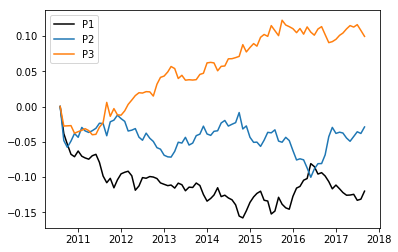

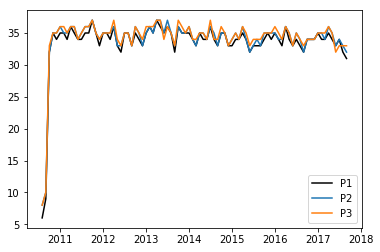

In [22]:
b2_monthly_scores = produce_portfolio_results(b2_results_back, LIBRARY_PATH, num_portfolios=3, max_age=4)

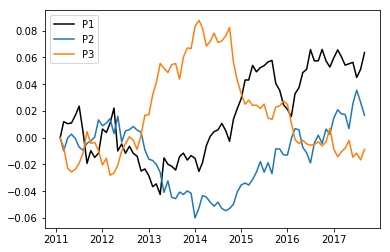

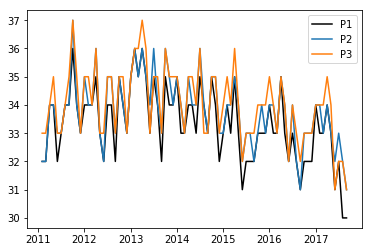

In [23]:
b2_changes = convert_monthly_scores_to_changes(b2_monthly_scores)
produce_portfolio_changes_results(b2_changes, LIBRARY_PATH, num_portfolios=3, max_age=4)




### Repeatedness: Model 2 n-gram overlap

### N-gram overlap pre-processing a document

In [46]:
# Procedure to get a list of n-grams from a document in a list 
def get_n_grams(words, n=3):
    n_grams = [words[i-(n-1):i+1] for i in range(n-1, len(words))]
    return n_grams

# Calculate the proportion of matching n_grams between MD and QA answers. It is useful for
# determining how correlated two documents are hence their relative informational value
def n_gram_overlap(comment, answers, n_grams=3):
    '''Calculate the proportion of matching n_grams between MD and QA answers. It is useful for
    determining how correlated two documents are hence their relative informational value'''
    n_gram_overlap = []
    # Get n-grams for the MD sections, default n_gram is 3 or tri-grams
    comment_n_grams = get_n_grams(comment, n_grams)
    # Get the n-grams in each answer and calculate their proportions of overlap
    for answer in answers:
        answer_n_gram = get_n_grams(answer, n_grams)
        matching_n_grams = sum([1 for n_gram in answer_n_gram if n_gram in comment_n_grams])
        n_gram_overlap.append(float(matching_n_grams)/len(answers))
    # Calculate the average proportion of overlap as a measure of repeatedness     
    repeatedness = sum(n_gram_overlap)/len(n_gram_overlap)
    return repeatedness


In [47]:
test = [str(i) for i in range(10)]
get_n_grams(test)

[['0', '1', '2'],
 ['1', '2', '3'],
 ['2', '3', '4'],
 ['3', '4', '5'],
 ['4', '5', '6'],
 ['5', '6', '7'],
 ['6', '7', '8'],
 ['7', '8', '9']]

In [48]:
def n_gram_overlap_pre_process_document(doc):
    tokenizer = RegexpTokenizer(r'\w+')  # This finds letters only and breaks things up at each non-letters character
    porter_stemmer = PorterStemmer()
    lower_doc = doc.lower()
    clean_lower_doc = remove_square_brackets(lower_doc)
    clean_doc = clean_text(clean_lower_doc)
    tokens = tokenizer.tokenize(clean_doc)
    stopped_tokens = [word for word in tokens if word not in stop_words]
    stemmed_tokens = [porter_stemmer.stem(i) for i in stopped_tokens]
    return stemmed_tokens


### Perform N-Gram Overlap Analysis

In [58]:
b3_results = {}
i = 0
report_every = 100
start_time = time.time()

# for f in TextFiles[:100]:
for f in raw_files:
    
#     (ticker, date, file_num) = get_filename_components(f, i)

#     ts = read_transcript(f)
    
    (ticker, date, file_num) = raw_files[f][0]

    ts = raw_files[f][1]
    
    if 'Earnings Call' in ts[0]:
        
        # Get Company Participants
        start = find_full_string_index(ts, CO_PART_HEADERS)
        end = find_full_string_index(ts, OTH_PART_HEADERS) - 1
        
        if start != -1 and end != -2: 
            co_part_names = get_parts(ts, start, end)

            # Get MD Section
            start = find_full_string_index(ts, MD_SECTION_HEADERS)
            end = find_full_string_index(ts, QA_SECTION_HEADERS) - 1
            MD = get_MD(ts, co_part_names, start, end)
            comments = [comment for comment in MD.values() if len(comment) > 20]
            comment = ' '.join(comments)
            
            # Pre-process and convert to a list of unique words
            comment = n_gram_overlap_pre_process_document(comment)

            # Get QA Section
            start = find_full_string_index(ts, QA_SECTION_HEADERS)
            end = find_disclaimer_index(ts, DISCLAIMER)
            QA = get_QA(ts, start, end)    
            # get the answers with a condition to ensure the answer is of at least some length
            answers = [answer for answer in QA.values() if len(answer) > 20]
            # convert to a list of unique word lists
            answers = [n_gram_overlap_pre_process_document(answer) for answer in answers]
            
            if date not in b3_results.keys():
                b3_results[date] = {}

            if len(answers) > 0:
                b3_results[date][ticker] = n_gram_overlap(comment, answers, n_grams=3)
        
        i += 1

        if i % report_every == 0:
            print "Processed ", i, "in ", time.time() - start_time, "seconds"
            
            

Processed  100 in  37.8951079845 seconds
Processed  200 in  80.267843008 seconds
Processed  300 in  122.188961983 seconds
Processed  400 in  166.458297014 seconds
Processed  500 in  211.897742033 seconds
Processed  600 in  255.560238123 seconds
Processed  700 in  297.845279932 seconds
Processed  800 in  337.123866081 seconds
Processed  900 in  376.196950912 seconds
Processed  1000 in  417.875884056 seconds
Processed  1100 in  458.951889992 seconds
Processed  1200 in  505.986540079 seconds
Processed  1300 in  548.741311073 seconds
Processed  1400 in  595.484597921 seconds
Processed  1500 in  636.25080204 seconds
Processed  1600 in  681.403314114 seconds
Processed  1700 in  724.827256918 seconds
Processed  1800 in  769.378500938 seconds
Processed  1900 in  809.954749107 seconds
Processed  2000 in  856.11518693 seconds
Processed  2100 in  899.913150072 seconds
Processed  2200 in  943.038317919 seconds
Processed  2300 in  987.41830492 seconds
Processed  2400 in  1032.49289608 seconds
Proce

In [59]:
b3_results

{'20100730': {'AEP': 0.05231866825208086,
  'CVX': 0.012855831037649219,
  'MET': 0.019204389574759943,
  'MRK': 0.31999999999999995,
  'SPG': 0.003023431594860166,
  'WY': 0.013079667063020214},
 '20100803': {'BHI': 0.024973985431841827,
  'DOW': 0.019999999999999997,
  'DUK': 0.003121748178980229,
  'EMR': 0.010009765625,
  'ETR': 0.017777777777777778,
  'MA': 0.024793388429752063,
  'NYX': 0.25,
  'PCLN': 0.05325443786982249,
  'PFE': 0.5,
  'PG': 0.0},
 '20100804': {'CHTR': 0.07111111111111111,
  'DVN': 0.026627218934911243,
  'FOXA': 0.018595041322314047,
  'TWX': 0.07407407407407408},
 '20100805': {'AGN': 0.004382761139517896,
  'ALL': 0.010707911957168352,
  'MDLZ': 0.006198347107438018},
 '20100810': {'DIS': 0.03703703703703704},
 '20100811': {'CSCO': 0.25},
 '20100812': {'GM': 0.011446409989594173, 'HSH': 0.008506616257088847},
 '20100816': {'LOW': 0.029384756657483926},
 '20100817': {'HD': 0.03114186851211073},
 '20100818': {'TGT': 0.09523809523809523},
 '20100819': {'DELL': 

In [60]:
with open("uniqueness2_1209.txt", "w") as f:
    f.write(json.dumps(b3_results))

In [24]:
with open("uniqueness2_1209.txt", "r") as f:
    b3_results_back = json.loads(f.read())

In [25]:
b3_results_back

{u'20100730': {u'AEP': 0.05231866825208086,
  u'CVX': 0.012855831037649219,
  u'MET': 0.019204389574759943,
  u'MRK': 0.31999999999999995,
  u'SPG': 0.003023431594860166,
  u'WY': 0.013079667063020214},
 u'20100803': {u'BHI': 0.024973985431841827,
  u'DOW': 0.019999999999999997,
  u'DUK': 0.003121748178980229,
  u'EMR': 0.010009765625,
  u'ETR': 0.017777777777777778,
  u'MA': 0.024793388429752063,
  u'NYX': 0.25,
  u'PCLN': 0.05325443786982249,
  u'PFE': 0.5,
  u'PG': 0.0},
 u'20100804': {u'CHTR': 0.07111111111111111,
  u'DVN': 0.026627218934911243,
  u'FOXA': 0.018595041322314047,
  u'TWX': 0.07407407407407408},
 u'20100805': {u'AGN': 0.004382761139517896,
  u'ALL': 0.010707911957168352,
  u'MDLZ': 0.006198347107438018},
 u'20100810': {u'DIS': 0.03703703703703704},
 u'20100811': {u'CSCO': 0.25},
 u'20100812': {u'GM': 0.011446409989594173, u'HSH': 0.008506616257088847},
 u'20100816': {u'LOW': 0.029384756657483926},
 u'20100817': {u'HD': 0.03114186851211073},
 u'20100818': {u'TGT': 0.09

### Portfolio results

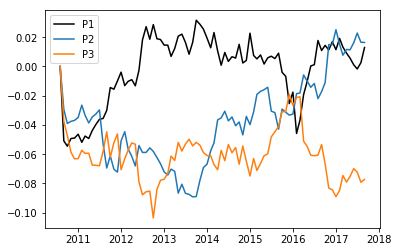

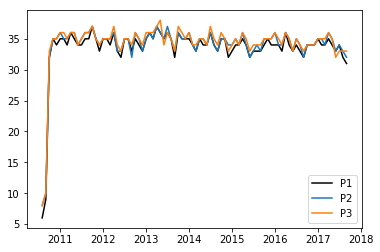

In [26]:
b3_monthly_scores = produce_portfolio_results(b3_results_back, LIBRARY_PATH, num_portfolios=3, max_age=4)

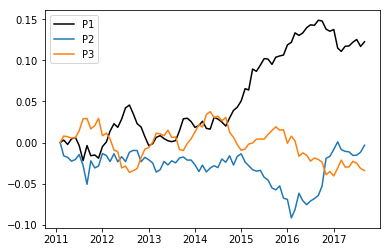

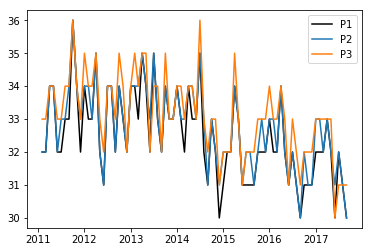

In [27]:
b3_changes = convert_monthly_scores_to_changes(b3_monthly_scores)
produce_portfolio_changes_results(b3_changes, LIBRARY_PATH, num_portfolios=3, max_age=4)




# LDA Approach

http://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html

### Install packages

In [ ]:
#!pip install --index-url=http://pypi.python.org/simple/ --trusted-host pypi.python.org gensim

In [112]:
#!pip install --index-url=http://pypi.python.org/simple/ --trusted-host pypi.python.org smart_open

In [9]:
# import gensim

### Constructing a document-term matrix

The result of our cleaning stage is `texts`, a tokenized, stopped and stemmed list of words from a list of documents. 

To generate an LDA model, we need to understand how frequently each term occurs within each document. To do that, we need to construct a document-term matrix with a package called gensim:

In [118]:
def replace_number(token):
    if token.isdigit():
        return "NUM"
    else:
        return token

In [119]:
test_doc = ['okay', u'current', 'end', 'year', '2011']
[replace_number(t) for t in test_doc]

['okay', u'current', 'end', 'year', 'NUM']

In [120]:
def testLDA_pre_process_document(doc):
    tokenizer = RegexpTokenizer(r'\w+')  # This finds letters only and breaks things up at each non-letters character
    porter_stemmer = PorterStemmer()
    lower_doc = doc.lower()
    clean_lower_doc = remove_square_brackets(lower_doc)
    clean_doc = clean_text(clean_lower_doc)
    tokens = tokenizer.tokenize(clean_doc)
    stopped_tokens = [t for t in tokens if not t in stop_words]
    stemmed_tokens = [porter_stemmer.stem(i) for i in stopped_tokens]
    replaced_num_tokens = [replace_number(t) for t in stemmed_tokens]
    return replaced_num_tokens

### Learn topic model, apply to Q&A pairs and evaluate similarity of Qs and As

In [121]:
def extract_raw_qa(source_list, output_file):
    '''Extract raw Q and A text from a list of files and put a structured dictionary
       of the extracted Q & A pairs into an output file.
       
       Returns a dictionary of raw Q&A pairs'''
    
    rawtext_qa = defaultdict(dict)
    i = 0
    report_every = 500
    start_time = time.time()
    
    for f in source_list:
    
        (ticker, date, file_num) = get_filename_components(f, i)

        file_id = ticker+"_"+date

        ts = read_transcript(f)

        # Get Company Participants
        start = find_full_string_index(ts, CO_PART_HEADERS)
        end = find_full_string_index(ts, OTH_PART_HEADERS) - 1
        if start != -1 and end != -2: 
            co_part_names = get_parts(ts, start, end)

            # Get QA Section
            start = find_full_string_index(ts, QA_SECTION_HEADERS)
            end = find_disclaimer_index(ts, DISCLAIMER)
            QA = get_QA(ts, start, end)

            # get the QA pairs with a condition to ensure both of at least some length
            q_number = 0
            for question in QA:

                # store indexed rawtext for easier inspection later
                rawtext_qa[file_id][q_number] = (question, QA[question])
                
                q_number += 1

        i += 1
        if i % report_every == 0:
            print "Processed ", i, "transcripts in ", time.time() - start_time, "seconds"
            
    # Also store the rawtext pairs, for easier inspection later
    with open(output_file, "w") as f:
        f.write(json.dumps(rawtext_qa))
    
    print "Finished extracting q and a text from all", i, "transcripts in ", time.time() - start_time, "seconds"
    
    return rawtext_qa

In [122]:
rawtext_qa = extract_raw_qa(TextFiles, "raw_qa_data.txt")

Processed  500 transcripts in  1.40946888924 seconds
Processed  1000 transcripts in  2.7840180397 seconds
Processed  1500 transcripts in  4.16287088394 seconds
Processed  2000 transcripts in  5.54024291039 seconds
Processed  2500 transcripts in  6.90222001076 seconds
Processed  3000 transcripts in  8.2473859787 seconds
Finished extracting q and a text from all 3245 transcripts in  9.29656505585 seconds


In [123]:
model_spec = {"model_directory": "saved_models/topic20_minlength20_base",
              "qa_pair_directory": "saved_models/standard_preproc",
              "preprocessing_function": "testLDA_pre_process_document",
              "min_sequence_length": 20,
              "num_topics": 20,
              "description": "test model"}

# maps function specs to function object
PREPRO_FUNCTIONS = {"testLDA_pre_process_document": testLDA_pre_process_document}

In [124]:
def save_model_spec(model_spec):
    '''Saves a model spec as a JSON in its specified directory'''
    if not os.path.exists(LIBRARY_PATH + model_spec["model_directory"]):
        os.mkdir(LIBRARY_PATH + model_spec["model_directory"])

    # Store the processed tokens in qa_pairs
    model_spec_path = LIBRARY_PATH+model_spec["model_directory"]+"/model_spec.txt"
    with open(model_spec_path, "w") as f:
        f.write(json.dumps(model_spec))

In [79]:
save_model_spec(model_spec)

In [208]:
def process_raw_qa_pairs(rawtext_qa, model_spec):
    '''Turns raw text q and a pairs into processed token sequences using prepro_func
       passed to it.
       
       Returns a dictionary of processed q and a pairs.'''
    
    qa_pairs = defaultdict(dict)
    start_time = time.time()
    i = 0
    report_every = 2500
    
    prepro_func = PREPRO_FUNCTIONS[model_spec["preprocessing_function"]]
    
    # Assemble a unified training texts list from all the qualifying processed Q&A pairs found
    for file_id in rawtext_qa:
        for q_number in rawtext_qa[file_id]:
            
            procd_question = prepro_func(rawtext_qa[file_id][q_number][0])
            procd_answer = prepro_func(rawtext_qa[file_id][q_number][1])
            
            qa_pairs[file_id][q_number] = (procd_question, procd_answer)
            
            i += 1
            if i % report_every == 0:
                print "Processed ", i, "pairs in ", time.time() - start_time, "seconds"
                    
    print "Finished all", i, "raw q and a pairs in ", time.time() - start_time, "seconds"
            
    return qa_pairs


In [209]:
qa_pairs = process_raw_qa_pairs(rawtext_qa, model_spec)

Processed  2500 pairs in  12.8997478485 seconds
Processed  5000 pairs in  25.6970510483 seconds
Processed  7500 pairs in  38.320941925 seconds
Processed  10000 pairs in  51.6792049408 seconds
Processed  12500 pairs in  64.0966398716 seconds
Processed  15000 pairs in  77.1172120571 seconds
Processed  17500 pairs in  89.1639368534 seconds
Processed  20000 pairs in  101.563796997 seconds
Processed  22500 pairs in  115.316822052 seconds
Processed  25000 pairs in  129.452033043 seconds
Processed  27500 pairs in  142.402493 seconds
Processed  30000 pairs in  155.258224964 seconds
Processed  32500 pairs in  168.497177839 seconds
Processed  35000 pairs in  181.161659002 seconds
Processed  37500 pairs in  193.736552954 seconds
Processed  40000 pairs in  206.73146987 seconds
Processed  42500 pairs in  219.533543825 seconds
Processed  45000 pairs in  232.622267008 seconds
Processed  47500 pairs in  246.601305962 seconds
Processed  50000 pairs in  259.877588987 seconds
Processed  52500 pairs in  2

In [210]:
# Store the processed tokens in qa_pairs
qa_path = LIBRARY_PATH+model_spec["qa_pair_directory"]+"/qa_pairs.txt"
qa_path
with open(qa_path, "w") as f:
    f.write(json.dumps(qa_pairs))

In [211]:
def select_texts(qa_pairs, model_spec):
    '''Assembles a unified set of training texts, that conforms with the 
       model specification.'''
    
    # Assemble a unified training texts list from all the qualifying processed Q&A pairs found
    texts = []
    min_sequence_length = model_spec["min_sequence_length"]
    
    count_accepted = 0
    count_rejected = 0
    
    for file_id in qa_pairs:
        for q_number in qa_pairs[file_id]:
            question, answer = qa_pairs[file_id][q_number]
            if (len(question) > min_sequence_length and
                len(answer) > min_sequence_length):
                texts.append(question)
                texts.append(answer)
                count_accepted += 1
            else:
                count_rejected +=1
                
    print count_accepted, "pairs met minimum length."
    print count_rejected, "were rejected."
                
    return texts

In [212]:
texts = select_texts(qa_pairs, model_spec)

37304 pairs met minimum length.
47502 were rejected.


Mean text token length 66.2845003217
Median text token length 48.0
SD text token length 53.0063107483


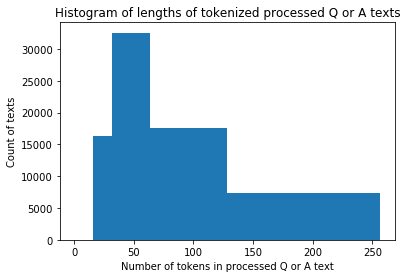

In [213]:
# Look at distribution of lengths of q's and a's
procd_lengths = []
for t in texts:
    procd_lengths.append(len(t))
    
print "Mean text token length", np.mean(procd_lengths)
print "Median text token length", np.median(procd_lengths)
print "SD text token length", np.std(procd_lengths)

plt.hist(procd_lengths, bins = [1,2,4,8,16,32,64,128,256])
plt.xlabel("Number of tokens in processed Q or A text")
plt.ylabel("Count of texts")
plt.title("Histogram of lengths of tokenized processed Q or A texts")

In [163]:
# test_texts = texts[:1000]

In [186]:
def learn_LDA_model(model_spec, texts):
    '''Learns an LDA model according to the model spec and stores the associated files'''
    
    model_dir = LIBRARY_PATH+model_spec["model_directory"]
    
    # Set up logging to file for Gensim progress

    # Clear any other logging handlers
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)
        
    logging.basicConfig(filename=model_dir+'/lda_logfile.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
   
    # Convert the texts from all the Questions and Answers into integer form and save
    dictionary = corpora.Dictionary(texts)
    dictionary.save(model_dir+"/dictionary.txt")
    
    # Create and save corpus
    corpus = [dictionary.doc2bow(text) for text in texts]
    with open(model_dir+"/corpus.txt", "w") as f:
        f.write(json.dumps(corpus))
        
    # Fit the LDA model

    start_time = time.time()
    print "fitting model"
    # Fit LDA model
    ldamodel = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                               num_topics=model_spec["num_topics"],
                                               id2word = dictionary,
                                               passes=10,
                                               eval_every = 10)
    
    print "model fitting took", time.time() - start_time, "seconds"
    
    # Remove logging handlers
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)
    
    # Save the learned model to file
    ldamodel.save(model_dir + "/full_model")
    
    # Save a UTC timestamp into the directory
    model_run_at = str(datetime.datetime.utcnow())
    with open(model_dir+"/model_runtime.txt", "w") as f:
        f.write(model_run_at)
        
    

In [214]:
learn_LDA_model(model_spec, texts)

fitting model
model fitting took 1312.81463289 seconds


In [217]:
def calc_hellinger_sims(model_spec):
    '''Calc hellinger similarities for a model and its data.'''

    hellinger_sims = defaultdict(dict)
    
    model_dir = LIBRARY_PATH+model_spec["model_directory"]
    qa_dir = LIBRARY_PATH+model_spec["qa_pair_directory"]
    
    with open(qa_dir+"/qa_pairs.txt", "r") as f:
        qa_pairs = json.loads(f.read())
        
    ldamodel = gensim.models.ldamodel.LdaModel.load(model_dir+"/full_model")
    dictionary = gensim.corpora.dictionary.Dictionary.load(model_dir+"/dictionary.txt")

    start_time = time.time()
    i = 0
    report_every = 5000
    
    min_sequence_length = model_spec["min_sequence_length"]

    for file_id in qa_pairs:
        for q_number in qa_pairs[file_id]:
            question, answer = qa_pairs[file_id][q_number]
            if (len(question) > min_sequence_length and
                len(answer) > min_sequence_length):
                q_bow = dictionary.doc2bow(question)
                a_bow = dictionary.doc2bow(answer)
                lda_q_bow = ldamodel[q_bow]
                lda_a_bow = ldamodel[a_bow]
                hellinger_sims[file_id][q_number] = hellinger(lda_q_bow, lda_a_bow)
            i += 1
            if i % report_every == 0:
                print "Processed ", i, "pairs in", time.time() - start_time
    print "Finished in", time.time() - start_time
    
    # Store the corpus to file for recreating model later if wanted
    with open(model_dir+"/hell_sims.txt", "w") as f:
        f.write(json.dumps(hellinger_sims))
    

In [218]:
calc_hellinger_sims(model_spec)

Processed  5000 pairs in 7.2103061676
Processed  10000 pairs in 14.3560471535
Processed  15000 pairs in 21.4103810787
Processed  20000 pairs in 27.8679111004
Processed  25000 pairs in 34.4481210709
Processed  30000 pairs in 41.3176190853
Processed  35000 pairs in 47.861287117
Processed  40000 pairs in 54.6403620243
Processed  45000 pairs in 61.2891290188
Processed  50000 pairs in 67.7445921898
Processed  55000 pairs in 74.0677371025
Processed  60000 pairs in 80.7263610363
Processed  65000 pairs in 86.8954529762
Processed  70000 pairs in 93.0327591896
Processed  75000 pairs in 100.01605916
Processed  80000 pairs in 106.184391022
Finished in 111.961220026


## Restoring from a saved state

Since training the models and processing the text is quite time consuming, it's useful to be able to restore a saved model.  Gensim makes saving and restoring a model easy, but we will often want to also be able to look at the data associated with that model.  This data may not always be the same, because we may apply different preprocessing to the raw transcript text to test the impact of that on the quality of the models.

We also may want to generate multiple models from the same processed set of data with different LDA hyperparameters (e.g. number of topics) so the same inpiut data might be associated with multiple LDA models.

To make this easy during experimentation this is a class that recovers a saved state from files on disk.  The state is specified by the model_spec dictionary of files so it is very easy to handle any combination of data and models (as long as we kept track in the first place of what data created what model).

In [125]:
class Saved_state():
    '''Represents a saved state that includes an LDA model and the data used to create it.
    
       Instantiated with a model_spec dictionary that locates the files to 
       recreate the saved state and includes a description.
       
       Dictionary needs to contain:
       
       model_files
       qa_pairs_file
       raw_qa_text_file
       corpus_file
       hellinger_file
       '''
    def __init__(self, model_spec):
        
        model_dir = LIBRARY_PATH+model_spec["model_directory"]
        qa_dir = LIBRARY_PATH+model_spec["qa_pair_directory"]
        
        self.ldamodel = gensim.models.ldamodel.LdaModel.load(model_dir+"/full_model")
        
        self.dictionary = gensim.corpora.dictionary.Dictionary.load(model_dir+"/dictionary.txt")
        
        with open(qa_dir+"/qa_pairs.txt", "r") as f:
            self.qa_pairs = json.loads(f.read())
            
        with open(LIBRARY_PATH + "/raw_qa_data.txt", "r") as f:
            self.raw_qa_text = json.loads(f.read())
            
        with open(model_dir+"/corpus.txt", "r") as f:
            self.corpus = json.loads(f.read())
            
        with open(model_dir+"/hell_sims.txt", "r") as f:
            self.hellinger_sims = json.loads(f.read())
            
        with open(model_dir+"/model_runtime.txt", "r") as f:
            self.model_runtime = f.read()

In [126]:
saved = Saved_state(model_spec)

In [127]:
# Restoring saved state

ldamodel = saved.ldamodel
qa_pairs= saved.qa_pairs
raw_qa_text = saved.raw_qa_text
corpus = saved.corpus
hellinger_sims = saved.hellinger_sims
dictionary = saved.dictionary
model_runtime = saved.model_runtime

print "Restored", model_spec["description"], "originally run at", model_runtime

Restored test model originally run at 2017-12-09 22:12:32.176898


In [128]:
# Display top 10 terms for each topic, with intrinsic UMass measure
# of coherence
ldamodel.top_topics(corpus = corpus, coherence = "u_mass", topn = 10)

[([(0.068563925839143877, u'quarter'),
   (0.051281775440546108, u'year'),
   (0.029050990360902168, u'margin'),
   (0.019875884381063889, u'first'),
   (0.016467304801215756, u'expect'),
   (0.015290766635550245, u'think'),
   (0.014543164344498923, u'second'),
   (0.014020016899665606, u'NUM'),
   (0.013462174589450513, u'half'),
   (0.011965256460273244, u'see')],
  -1.1794846699919062),
 ([(0.043859263094249264, u'market'),
   (0.037740502524278928, u'growth'),
   (0.025804702956057284, u'see'),
   (0.022996008463372339, u'busi'),
   (0.022607770019268336, u'think'),
   (0.015281571217101641, u'u'),
   (0.013364128866949553, u'year'),
   (0.013207761844962657, u'europ'),
   (0.011368699152513699, u'NUM'),
   (0.011304330270396418, u'look')],
  -1.1882724865153649),
 ([(0.038554639764875533, u'go'),
   (0.03850854224471241, u'think'),
   (0.02214809190313325, u'get'),
   (0.017020700698259009, u'year'),
   (0.016882405045071488, u'thing'),
   (0.012759122082361851, u'lot'),
   (0.01

In [129]:
# Display the coherence and topics in a little more readable form
scored_topics = ldamodel.top_topics(corpus = corpus, coherence = "u_mass", topn = 20)
for t in scored_topics:
    print
    print "U_mass Coherence is ", "{:3.2f}".format(t[1])
    print "Top 10 tokens in topic are:"
    for token_tuple in t[0]:
        print "{:10}{:3.2f}".format(token_tuple[1], token_tuple[0])


U_mass Coherence is  -1.27
Top 10 tokens in topic are:
go        0.04
think     0.04
get       0.02
year      0.02
thing     0.02
lot       0.01
cost      0.01
time      0.01
look      0.01
right     0.01
see       0.01
say       0.01
know      0.01
us        0.01
like      0.01
kind      0.01
realli    0.01
got       0.01
back      0.01
good      0.01

U_mass Coherence is  -1.38
Top 10 tokens in topic are:
busi      0.03
think     0.02
continu   0.02
us        0.01
realli    0.01
product   0.01
well      0.01
make      0.01
custom    0.01
opportun  0.01
look      0.01
invest    0.01
market    0.01
work      0.01
valu      0.01
thing     0.01
term      0.01
also      0.01
drive     0.01
go        0.01

U_mass Coherence is  -1.59
Top 10 tokens in topic are:
quarter   0.07
year      0.05
margin    0.03
first     0.02
expect    0.02
think     0.02
second    0.01
NUM       0.01
half      0.01
see       0.01
look      0.01
last      0.01
go        0.01
fourth    0.01
impact    0.01
revenu 

## Exploring topic similarities

Mean similarity 0.451143700407
SD similarity 0.110161203007


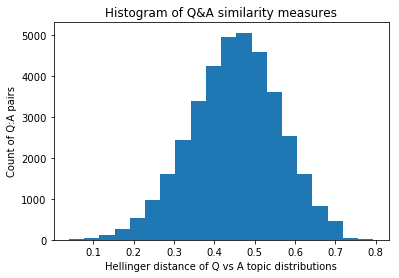

In [130]:
# Create a vector for all the similarity scores
all_sims = []
for file_id in hellinger_sims:
    for q_number in hellinger_sims[file_id]:
        all_sims.append((hellinger_sims[file_id][q_number],(file_id, q_number)))

sim_vals = [v[0] for v in all_sims]
print "Mean similarity", np.mean(sim_vals)
print "SD similarity", np.std(sim_vals)

plt.hist(sim_vals, bins = 20)
plt.xlabel("Hellinger distance of Q vs A topic distributions")
plt.ylabel("Count of Q:A pairs")
plt.title("Histogram of Q&A similarity measures")

In [131]:
from operator import itemgetter
all_sims.sort(key=itemgetter(0))
all_sims

[(0.03915893740428277, (u'MDLZ_20141105', u'28')),
 (0.04409765310143087, (u'FOXA_20151104', u'4')),
 (0.04592145846423646, (u'BAC_20111018', u'7')),
 (0.05510458088401503, (u'GS_20140116', u'17')),
 (0.05510589479441317, (u'SO_20120425', u'10')),
 (0.05813340438846647, (u'NKE_20110317', u'28')),
 (0.05829237835511105, (u'JPM_20110114', u'64')),
 (0.06004239471429534, (u'ABT_20130417', u'1')),
 (0.06417457132590723, (u'MO_20120127', u'14')),
 (0.0672456219002439, (u'OXY_20130131', u'33')),
 (0.0676721999765072, (u'C_20150115', u'49')),
 (0.07303675384859257, (u'C_20160415', u'40')),
 (0.07307911633158037, (u'FCX_20120119', u'8')),
 (0.07328554123194136, (u'NSC_20130122', u'56')),
 (0.07414578961659839, (u'LLY_20121024', u'1')),
 (0.07549475683027868, (u'LOW_20150225', u'17')),
 (0.07614302041116465, (u'XOM_20160729', u'7')),
 (0.07686760351462106, (u'RF_20150120', u'2')),
 (0.07828831232726122, (u'GILD_20131029', u'13')),
 (0.07900715737025892, (u'COP_20130425', u'3')),
 (0.07992826730

In [132]:
# Display the closest n based on distance between q and a

n = 3
for record in all_sims[:n]:
    print
    print "Hellinger Distance of topics is {:4.3f}".format(record[0])
    q_text, a_text = rawtext_qa[record[1][0]][int(record[1][1])]
    print "Question:"
    print q_text
    print "Answer:"
    print a_text


Hellinger Distance of topics is 0.039
Question:
Okay. And then, in terms of pricing, have you basically taken all the pricing you need so far, based on what you know in terms of commodity costs and FX transaction? Obviously, not knowing what's going to happen down the road, but just trying to make a sense is, you've been putting pricing in for the second quarter or the third quarter. For now, are you primarily done with that, or is there still more new pricing that has to be instituted?
Answer:
It varies a lot by market and category, but I guess two parts to it, we have announced more price increases in some markets, but none of that is required to hit the quarter four. So, that's more about making sure we continue to stay on the cost curve as we go into next year. So, there is more pricing coming through, but it's not necessary to hit the quarter four guidance we just gave you.

Hellinger Distance of topics is 0.044
Question:
Thanks. I'll ask one to John on costs. John, you said that

In [133]:
# Display the furthest n based on distance between q and a

n = 3
for record in all_sims[-n:]:
    print
    print "Hellinger Distance of topics is {:4.3f}".format(record[0])
    q_text, a_text = rawtext_qa[record[1][0]][int(record[1][1])]
    print "Question:"
    print q_text
    print "Answer:"
    print a_text


Hellinger Distance of topics is 0.788
Question:
Thanks. Good morning. Matt, just wanted to get your views on the recent industry debate on refracking in the unconventional, and if I could ask two questions on that. First, from Conoco's vantage point, what is new in the technology offering that you are seeing? And second, within your portfolio where do you see the most relevance? And if you could frame that on a risk-reward context, please.
Answer:
Yeah, so we have been running some refracks in our portfolio, some using the diverter technology, some just basically straight pumping new fracks on existing pairs and some with new pairs. So we've been testing a few. The area that we're seeing the best uplift is, as you'd expect, are older wells where we pump smaller jobs with wider spacing. So we see some potential there and it's particularly in wells that were drilled a few years ago, not on more recently-drilled wells. So we're continuing to evaluate that, but there is certainly some ups

In [134]:
n = 3
for record in all_sims[-n:]:
    print record

(0.7880791412262029, (u'COP_20150430', u'23'))
(0.7928194648051035, (u'WMT_20130516', u'50'))
(0.7940466021723197, (u'BAX_20120419', u'4'))


In [135]:
question, answer = qa_pairs['LMT_20110426']['4']
print question
print answer
q_bow = dictionary.doc2bow(question)
a_bow = dictionary.doc2bow(answer)
lda_q_bow = ldamodel[q_bow]
lda_a_bow = ldamodel[a_bow]
print lda_q_bow
print lda_a_bow

[u'yeah', u'good', u'morn', u'bob', u'bruce']
[u'good', u'morn', u'good', u'morn', u'peter']
[(4, 0.31274600702813554), (6, 0.36943274199841558), (15, 0.17615458229131051)]
[(0, 0.19393890318158319), (6, 0.65606109632939191)]


In [136]:
print ldamodel.print_topic(6, topn = 7)

0.047*"thank" + 0.044*"question" + 0.027*"mayb" + 0.021*"guess" + 0.019*"like" + 0.018*"guy" + 0.018*"kind"


Why does the topic probabilities not sum to 1?  Apparently because it automatically filters out below a certain minimum probability.  See https://groups.google.com/forum/#!topic/gensim/F4AWfh9yIhM  
  
Can access the full topic vector as below...


In [137]:
print ldamodel.get_document_topics(q_bow, minimum_probability=0.0)

[(0, 0.0083333333684301927), (1, 0.0083333334235901908), (2, 0.0083333336078978172), (3, 0.0083333336001328428), (4, 0.3128165292729454), (5, 0.0083333335511840204), (6, 0.3693642572120816), (7, 0.0083333335097061038), (8, 0.0083333333834061264), (9, 0.0083333337087318857), (10, 0.0083333333337772351), (11, 0.0083333333363881327), (12, 0.0083333333662325201), (13, 0.0083333334691084431), (14, 0.0083333333333333332), (15, 0.17615254483506301), (16, 0.0083333333333333332), (17, 0.0083333334892835374), (18, 0.0083333333362024462), (19, 0.0083333335291718696)]


In [138]:
# Calc some stats on hellinger similarity and identify max and min
max_dist = -1
min_dist = 2
max_record_id = (None, None)
min_record_id = (None, None)

for file_id in hellinger_sims:
    for q_number in hellinger_sims[file_id]:
        this_sim = hellinger_sims[file_id][q_number]
        if this_sim > max_dist:
            max_dist = this_sim
            max_record_id = (file_id, q_number)
        if this_sim < min_dist:
            min_dist = this_sim
            min_record_id = (file_id, q_number)
        
        
print max_dist
print max_record_id
print qa_pairs[max_record_id[0]][max_record_id[1]]
print rawtext_qa[max_record_id[0]][int(max_record_id[1])]
print
print min_dist
print min_record_id
print qa_pairs[min_record_id[0]][min_record_id[1]]
print rawtext_qa[min_record_id[0]][int(min_record_id[1])]

0.794046602172
(u'BAX_20120419', u'4')
[[u'good', u'morn', u'bob', u'good', u'morn', u'everybodi', u'coupl', u'thing', u'apolog', u'jump', u'littl', u'bit', u'late', u'review', u'updat', u'home', u'hemo', u'product', u'time', u'expect', u'get', u'product', u'launch', u'go'], [u'yeah', u'actual', u'rick', u'time', u'question', u'norbert', u'mari', u'kay', u'want', u'give', u'specif', u'yeah', u'yeah', u'studi', u'actual', u'ongo', u'clinic', u'studi', u'character', u'patient', u'therapi', u'realli', u'like', u'therapi', u'sinc', u'restart', u'issu', u'deal', u'therefor', u'project', u'timelin', u'remain', u'ce', u'mark', u'NUM', u'u', u'launch', u'NUM', u'u', u'file', u'NUM', u'sorri']]
("Good morning, Bob. Good morning, everybody. Just a couple things, and I apologize, I jumped on a little bit late. Did you review any update on the home hemo product timing and when you're expecting to get that product launched and going?", "Yeah, actually we did not, Rick, so it's a timely question. So

In [139]:
# Display a few stats about the q&a data
print "Number of files", len(qa_pairs.keys())
print "Total number of Q&A pairs evaluated", sum(len(qa_pairs[f]) for f in qa_pairs)
total_tokens = 0
for file_id in qa_pairs:
    for q_number in qa_pairs[file_id]:
        len_q = len(qa_pairs[file_id][q_number][0])
        len_a = len(qa_pairs[file_id][q_number][1])
        total_tokens += (len_q + len_a)
print "Total number of tokens", total_tokens

Number of files 3088
Total number of Q&A pairs evaluated 84806
Total number of tokens 6583595


## Extracting information to inspect topics and errors

In [62]:
from gensim.models.coherencemodel import CoherenceModel

In [247]:
cm = CoherenceModel(model = ldamodel, corpus = corpus, coherence = "u_mass", topn = 10)

In [248]:
umass_by_topic = cm.get_coherence_per_topic()
umass_by_topic

[-2.3713590609904478,
 -1.6270944386065846,
 -1.1794846699919062,
 -1.4033290494957751,
 -2.5218127764768736,
 -1.1882724865153649,
 -1.4229830860744079,
 -2.0026881828901457,
 -1.8098617141957354,
 -1.2334637234636505,
 -3.530683989246485,
 -6.0218491084458172,
 -2.508585957312933,
 -2.4109218380689184,
 -3.2737908138570164,
 -3.2697170459446077,
 -2.3091131200748953,
 -1.4831962209501304,
 -1.6388650117446013,
 -1.3359749128044207]

Get top n texts that are most associated with each topic.

In [249]:
topic_weights = defaultdict(list)

start_time = time.time()
i = 0
report_every = 5000

for file_id in qa_pairs:
    for q_number in qa_pairs[file_id]:
        question, answer = qa_pairs[file_id][q_number]
        q_bow = dictionary.doc2bow(question)
        a_bow = dictionary.doc2bow(answer)
        lda_q_bow = ldamodel[q_bow]
        lda_a_bow = ldamodel[a_bow]
        for topic_tuple in lda_q_bow:
            topic_num, weight = topic_tuple
            topic_weights[topic_num].append((weight, file_id, q_number, "q"))
        for topic_tuple in lda_a_bow:
            topic_num, weight = topic_tuple
            topic_weights[topic_num].append((weight, file_id, q_number, "a"))           
            
        i += 1
        if i % report_every == 0:
            print "Processed ", i, "pairs in", time.time() - start_time
print "Finished in", time.time() - start_time

Processed  5000 pairs in 12.1284148693
Processed  10000 pairs in 24.5551660061
Processed  15000 pairs in 36.6498939991
Processed  20000 pairs in 49.2851159573
Processed  25000 pairs in 60.7563669682
Processed  30000 pairs in 70.9596989155
Processed  35000 pairs in 81.1538438797
Processed  40000 pairs in 91.4983818531
Processed  45000 pairs in 101.857344866
Processed  50000 pairs in 112.233368874
Processed  55000 pairs in 123.041217804
Processed  60000 pairs in 133.907956839
Processed  65000 pairs in 144.778133869
Processed  70000 pairs in 155.19232893
Processed  75000 pairs in 166.669613838
Processed  80000 pairs in 176.772995949
Finished in 186.453670025


In [250]:
n_highest = 5
n_terms = 20

for t in topic_weights:
    topn = sorted(topic_weights[t], reverse = True)[:n_highest]
    print "-" * 80
    print "Topic Number", t, ", u_mass coherence = ", umass_by_topic[t]
    print
    print "Top", n_terms, "terms for this topic are:\n"
    print ldamodel.print_topic(t, topn = n_terms)
    print
    print n_highest, "highest scoring texts for the topic are:\n"
    for topic_prob, file_id, q_num, qa_type in topn:
        print "Calced probability", topic_prob, ". Topic from Q or A - ", qa_type
        print "\nProcessed tokens:"
        print qa_pairs[file_id][q_num]
        print "\nRaw text:"
        print raw_qa_text[file_id][q_num]
        print



--------------------------------------------------------------------------------
Topic Number 0 , u_mass coherence =  -2.37135906099

Top 20 terms for this topic are:

0.053*"rate" + 0.028*"credit" + 0.027*"loan" + 0.023*"book" + 0.022*"portfolio" + 0.021*"loss" + 0.020*"ratio" + 0.018*"card" + 0.015*"reserv" + 0.014*"see" + 0.013*"quarter" + 0.012*"yield" + 0.012*"mortgag" + 0.010*"commerci" + 0.010*"point" + 0.009*"auto" + 0.009*"charg" + 0.008*"look" + 0.008*"higher" + 0.008*"interest"

5 highest scoring texts for the topic are:

Calced probability 0.920833332467 . Topic from Q or A -  a

Processed tokens:
[[u'degre', u'econom', u'environ', u'still', u'like', u'consensu', u'estim', u'come', u'expect', u'go', u'hit', u'lower', u'number', u'sub', u'NUM', u'end', u'NUM'], [u'ye', u'earn', u'lower', u'calcul', u'ratio', u'lower', u'earn', u'higher', u'calcul', u'ratio', u'higher']]

Raw text:
[u"So to the degree the economic environment is still like the consensus estimates, if it comes

## Observations from reviewing topics (not had time yet to review new ones yet)

TBD





In [140]:
# Convert sims to format for calculating portfolio returns

# create empty results dict
topic_sims_results = {}

for file_id in hellinger_sims:
    ticker, date = file_id.split('_')
    
    if date not in topic_sims_results.keys():
        topic_sims_results[date] = {}
        
    avg_sim = np.mean([hellinger_sims[file_id][q_num] for q_num in hellinger_sims[file_id]])

    topic_sims_results[date][ticker] = avg_sim


In [141]:
topic_sims_results

{u'20100730': {u'AEP': 0.43825143971271607,
  u'CVX': 0.41815945414689099,
  u'MET': 0.50193556460603805,
  u'MRK': 0.38733691438206075,
  u'SPG': 0.49760368899107715,
  u'WY': 0.46979903187503247},
 u'20100803': {u'BHI': 0.40308158521296483,
  u'DOW': 0.40573071505096903,
  u'DUK': 0.40612565119783173,
  u'EMR': 0.41620958171316952,
  u'ETR': 0.48183485783421603,
  u'MA': 0.52950398549612465,
  u'NYX': 0.42309722897249102,
  u'PCLN': 0.44201955985489144,
  u'PFE': 0.46307032865943171,
  u'PG': 0.57299093918671395},
 u'20100804': {u'CHTR': 0.52911814360315712,
  u'DVN': 0.46338930270505924,
  u'FOXA': 0.49578308395429205,
  u'TWX': 0.41232590587817175},
 u'20100805': {u'AGN': 0.47060874589363877,
  u'ALL': 0.47240658685690762,
  u'MDLZ': 0.44499087333664844},
 u'20100810': {u'DIS': 0.44392891533514273},
 u'20100812': {u'GM': 0.44834968358714578, u'HSH': 0.39981353979107681},
 u'20100816': {u'LOW': 0.46449733730304027},
 u'20100817': {u'HD': 0.3880884853726283},
 u'20100818': {u'TGT': 0

### Portfolio results

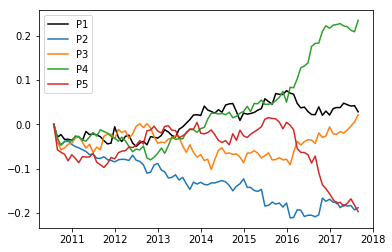

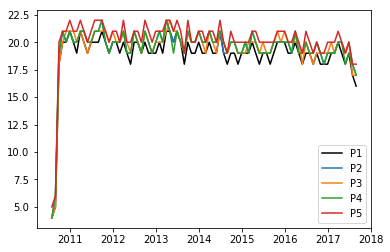

In [142]:
# produce_portfolio_results(topic_sims_results_back, LIBRARY_PATH, num_portfolios=5, max_age=4)
lda_monthly_scores = produce_portfolio_results(topic_sims_results, LIBRARY_PATH, num_portfolios=5, max_age=4)

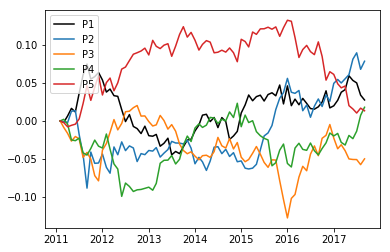

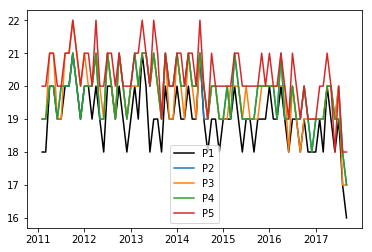

In [143]:
lda_changes = convert_monthly_scores_to_changes(lda_monthly_scores)
produce_portfolio_changes_results(lda_changes, LIBRARY_PATH, num_portfolios=5, max_age=4)




In [29]:
with open("topic_sims_1207.txt", "r") as f:
    lda_results_back = json.loads(f.read())

In [30]:
lda_results_back

{u'20100730': {u'AEP': 0.39592541666666664,
  u'CVX': 0.41415107142857144,
  u'MET': 0.4392316842105262,
  u'MRK': 0.67019725,
  u'SPG': 0.42146144,
  u'WY': 0.46350257692307684},
 u'20100803': {u'BHI': 0.34964227272727266,
  u'DOW': 0.5423684615384615,
  u'DUK': 0.49089526086956525,
  u'EMR': 0.3717094999999999,
  u'ETR': 0.28236041666666667,
  u'MA': 0.4459412857142856,
  u'NYX': 0.42942199999999997,
  u'PCLN': 0.536981909090909,
  u'PFE': 0.553757},
 u'20100804': {u'CHTR': 0.45344335714285716,
  u'DVN': 0.4463105652173912,
  u'FOXA': 0.297537375,
  u'TWX': 0.35369325},
 u'20100805': {u'AGN': 0.4977280714285715,
  u'ALL': 0.3472313333333334,
  u'MDLZ': 0.46878250000000005},
 u'20100810': {u'DIS': 0.4010282},
 u'20100811': {u'CSCO': 0.040574},
 u'20100812': {u'GM': 0.3927585357142858, u'HSH': 0.49547618421052614},
 u'20100816': {u'LOW': 0.4480750624999999},
 u'20100817': {u'HD': 0.5221363125},
 u'20100818': {u'TGT': 0.47541061111111105},
 u'20100819': {u'DELL': 0.513973, u'HPQ': 0.391

### Portfolio results

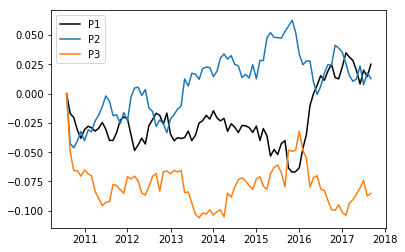

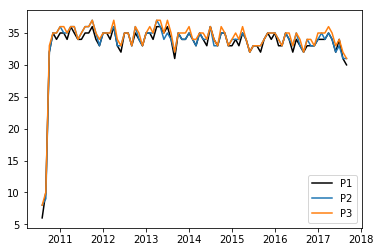

In [31]:
lda_monthly_scores = produce_portfolio_results(lda_results_back, LIBRARY_PATH, num_portfolios=3, max_age=4)

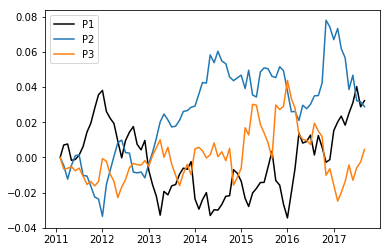

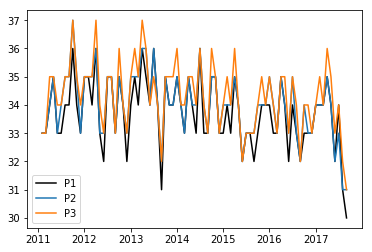

In [32]:
lda_changes = convert_monthly_scores_to_changes(lda_monthly_scores)
produce_portfolio_changes_results(lda_changes, LIBRARY_PATH, num_portfolios=3, max_age=4)




## Running with different parameters

In [259]:
model_spec = {"model_directory": "saved_models/topic10_minlength20_base",
              "qa_pair_directory": "saved_models/standard_preproc",
              "preprocessing_function": "testLDA_pre_process_document",
              "min_sequence_length": 20,
              "num_topics": 10,
              "description": "Topics 10, Min Length 20, Standard preprocessing"}

# maps function specs to function object
PREPRO_FUNCTIONS = {"testLDA_pre_process_document": testLDA_pre_process_document}

In [260]:
save_model_spec(model_spec)

# Can just load already preprocessed qa pairs as applying standard preprocessing
qa_dir = LIBRARY_PATH+model_spec["qa_pair_directory"]
with open(qa_dir+"/qa_pairs.txt", "r") as f:
    qa_pairs = json.loads(f.read())

texts = select_texts(qa_pairs, model_spec)

learn_LDA_model(model_spec, texts)

calc_hellinger_sims(model_spec)

37304 pairs met minimum length.
47502 were rejected.
fitting model
model fitting took 1201.13878608 seconds
Processed  5000 pairs in 6.14782905579
Processed  10000 pairs in 11.9813199043
Processed  15000 pairs in 17.6915299892
Processed  20000 pairs in 23.4205379486
Processed  25000 pairs in 29.1411418915
Processed  30000 pairs in 34.7916629314
Processed  35000 pairs in 40.389040947
Processed  40000 pairs in 46.4291470051
Processed  45000 pairs in 52.5091309547
Processed  50000 pairs in 58.2189180851
Processed  55000 pairs in 63.758754015
Processed  60000 pairs in 69.5108659267
Processed  65000 pairs in 74.9085888863
Processed  70000 pairs in 80.4578619003
Processed  75000 pairs in 86.7185089588
Processed  80000 pairs in 92.4055030346
Finished in 97.6371939182


In [ ]:
# build automatic search over remaining parameters
search_grid = [(10,10), (10, 40), (20, 10), (20, 40), (40, 10), (40, 20), 40, 40]

# Can just load already preprocessed qa pairs as applying standard preprocessing
qa_dir = LIBRARY_PATH+model_spec["qa_pair_directory"]
with open(qa_dir+"/qa_pairs.txt", "r") as f:
    qa_pairs = json.loads(f.read())

for num_topics, min_sequence_length in search_grid:
    
    model_dir = "saved_models/topic"+str(num_topics)+"_minlength"+str(min_sequence_length)+"_base"
    
    model_spec = {"model_directory": model_dir,
              "qa_pair_directory": "saved_models/standard_preproc",
              "preprocessing_function": "testLDA_pre_process_document",
              "min_sequence_length": min_sequence_length,
              "num_topics": num_topics,
              "description": "Topics "+str(num_topics)+", Min Length "+str(min_sequence_length)+", Standard preprocessing"}
    
    save_model_spec(model_spec)

    texts = select_texts(qa_pairs, model_spec)

    learn_LDA_model(model_spec, texts)

    calc_hellinger_sims(model_spec)

### Old code

In [49]:
# READ IN DICTIONARIES

def get_full_dict():
    """Read in the full McDonald and Loughran word list dictionary as a list"""
    file_path = dict_path + dict_name
    with open(file_path, "r") as file:
        words = [word.lower().rstrip('\n').split(',') for word in file]
    words_only = []
    for i in range(len(words)):
        words_only.append(words[i][0])
    return words_only


def get_bytes_replace_dict():
    """Read in the Non-UTF8 character dictionary as a dict with key=byte character, value=utf-8 character"""
    file_path = dict_path + bytes_dict_name
    with open(file_path, "r") as file:
        words = [word.rstrip('\n').split('\t') for word in file]
    bytes_replace_dict = {}
    for i in range(1, len(words)):
        bytes_replace_dict[words[i][1]] = words[i][2]
    return bytes_replace_dict


def get_result_file(result_name):
    """Result_name is a result file that is a '#' separated file"""
    file_path = dict_path + result_name
    with open(file_path, "r") as file:
        results = [word.rstrip('\n').split('#') for word in file]
    return results


# BASIC STRING FUNCTIONS

def remove_punctuation(my_string):
    """Remove all ASCII punctuation from my_string"""
    # NEED TO INCLUDE NO-UTF8 apostrophe replace
    my_str = short_form_replace(my_string)  # replace short forms with long forms before removing punctuation
    # my_str = ''.join(l for l in my_str if l not in string.punctuation)
    my_punc_remove = "-"
    my_punc = ''.join(l for l in string.punctuation if l not in my_punc_remove)
    my_str = ''.join(l for l in my_str if l not in my_punc)
    my_str = ' '.join(my_str.split())     # this changes all white spaces to single spaces
    return my_str


def remove_digits(my_string):
    """Remove all ASCII digits from my_string"""
    my_str = ''.join(l for l in my_string if l not in string.digits)
    my_str = ' '.join(my_str.split())     # this changes all white spaces to single spaces
    return my_str


def count_chars_words(my_string):
    """Number of characters and words in my_string. Numbers are deemed to be a word."""
    my_str = remove_punctuation(my_string)
    words = my_str.split(' ')
    num_words = len(words)
    num_chars = 0
    for word in words:
        num_chars += len(word)
    return num_chars, num_words


def count_words(my_string):
    """Number of words in my_string. Numbers are deemed to be a word."""
    my_str = remove_punctuation(my_string)
    words = my_str.split(' ')
    num_words = len(words)
    return num_words


def count_sentences(my_string):
    """Count the number of sentences in my_string"""
    my_str = my_string.rstrip()
    sent_ends = '.!?'
    num_sent = 0
    if len(my_str) < 2:
        return num_sent
    else:
        for i in range(2, len(my_str) - 2):
            # check for abbreviations like U.S.A. or e.g. or i.e. followed by a space then upper case letter
            if not(my_str[i] == my_str[i-2] == '.' and my_str[i-1] in string.ascii_letters):
                # check for sentence ending punctuation followed by a space and then an upper case letter
                if my_str[i] in sent_ends and my_str[i + 1] == ' ' and my_str[i + 2] in string.ascii_uppercase:
                    num_sent += 1
    # check special case of last character being a sentence end
    if my_str[-1] in sent_ends:
        num_sent += 1
    return num_sent


def convert_string_to_words(my_string):
    """Convert a string to a list of words"""
    my_str = remove_punctuation(my_string)
    my_str = remove_digits(my_str)
    words = my_str.split(' ')
    return words


def unique_words(my_string):
    """Create a list of unique words that appear in my_string"""
    words = set(convert_string_to_words(my_string))
    return words

def count_in_string(my_string):
    """Count the frequency of words in my_string"""
    words = convert_string_to_words(my_string)
    count = {word: words.count(word) for word in words}
    return count

# STRING FUNCTIONS THAT RELATE TO A DICTIONARY


def sum_in_words(my_string, words):
    """Total count of words in my_string that appear in the list words"""
    my_str = convert_string_to_words(my_string)
    count = sum([1 for word in my_str if word in words])
    return count


def count_in_words(my_string, words):
    """Frequency/count of each word in my_string that appear in the list words"""
    my_str = convert_string_to_words(my_string)
    count = {word: my_str.count(word) for word in words}
    return count


def remove_duplicates(count_dict):
    """Receives a count_in_words dictionary and returns a list of the unique words, i.e. only appear once."""
    unique_words_in_count = [key for key in count_dict.keys() if count_dict[key] == 1]
    return unique_words_in_count


def not_in_dictionary(my_string, words):
    """Returns a list of words that are in my_string, but not in the list words"""
    not_in = [word for word in unique_words(my_string.lower()) if word not in set(words)]
    return not_in


# COLLECT WORD TYPES FROM CORPUS

def short_form_replace_check(my_string):
    """Return a list of all short-form words or words with apostrophes in my_string"""
    result = []
    my_str = my_string
    for j in range(len(my_str)):
        if my_str[j] == '\'':
            n = j
            while my_str[n] != ' ':
                n += 1
                if n == len(my_str) - 1:
                    break
            m = j
            while my_str[m] != ' ':
                m -= 1
                if m == 0:
                    break
            result.append(my_str[m + 1:n].lower())
    result = sorted(list(set(result)))
    return result


def find_non_utf8_chars(my_string):
    """Returns a dict of all non-utf-8 characters with their byte encoded character and frequency from my_string"""
    my_str = my_string
    result = {}
    for char in my_str:
        if len(str(char.encode('utf-8'))) > 5:
            if char in result:
                result[char][1] += 1
            else:
                result[char] = [char.encode('utf-8'), 0]
    return result

def replace_non_utf8_apostrophes(my_str):
    """Replace most common non-utf-8 apostrophes with utf-8 apostrophes"""
    apostrophes = [str(b'\xe2\x80\x98'), str(b'\xe2\x80\x99')]
    for i in range(len(my_str)):
        if str(my_str[i].encode('utf-8')) in apostrophes:
            my_str = my_str[:i] + "'" + my_str[i+1:]
    return my_str



# CHECK THIS!!!!
def fi_replace(my_str):
    """Replace missing "fi's" in words that need them."""
    my_str = re.sub(r"(\s)(\?)([a-z])", r" fi\3", my_str)
    my_str = re.sub(r"(\s)(\?)(\s)([a-z])", r" fi\4", my_str)
    my_str = re.sub(r"([A-z])(\?)([a-z])", r"\1fi\3", my_str)
    my_str = re.sub(r"([A-z])(\?)(\s)([a-z])", r"\1fi\4", my_str)
    return my_str


def replace_non_utf8_chars(my_str):
    """Replace all non-utf8 characters with the user defined characters in the bytes_replace_dict"""
    byte_dict = get_bytes_replace_dict()
    for i in range(len(my_str)):
        if str(my_str[i].encode('utf-8')) in byte_dict:
            byte_key = str(my_str[i].encode('utf-8'))
            my_str = my_str[:i] + byte_dict[byte_key] + my_str[i+1:]
    my_str = my_str.replace('""""', '"')
    my_str = my_str.replace('\\\'', '\'')
    return my_str


def replace_fi_fl(my_str):
    """Replace 'fi' in any word that includes 'fi', where the word is not in the all_words dictionary,
    but where the word with 'fl' in place of 'fi' is in the all_words dictionary"""
    all_words = get_dictionary('All_words.txt')
    words = my_str.split(' ')
    for i in range(len(words)):
        if 'fi' in words[i]:
            if words[i] not in all_words:
                if words[i].replace('fi', 'fl') in all_words:
                    words[i] = words[i].replace('fi', 'fl')
    my_str = ' '.join(words)
    return my_str


def v1_v2_frequency_in_words(my_string1, my_string2, words):
    """Takes two strings and returns word matched frequency vectors ('a' & 'b') for a given dictionary 'words',
     which is useful for cosine similarity analysis."""
    count1 = count_in_words(my_string1, words)  # returns dict(keys:word in words, values:word frequency)
    count2 = count_in_words(my_string2, words)  # returns dict keys:word in words, values:word frequency)
    a = []
    b = []
    for key in count1.keys():                     # create two word frequency vectors 'a' and 'b'
        a.append(count1[key])
        b.append(count2[key])
    return a, b


def ferret(my_string1, my_string2, num_grams=3):
    """calculate the proportion of matching num_grams between two strings. It is useful for
    determining how correlated two strings are hence their relative informational value"""
    # converts strings to single word lists
    words1 = convert_string_to_words(my_string1.lower())
    words2 = convert_string_to_words(my_string2.lower())
    # aggregate single words into multi-word strings or num_grams, default is 3 or trigrams
    num_grams1 = []
    num_grams2 = []
    for i in range(num_grams-1, len(words1)):
        string1 = ''
        for j in range(num_grams - 1, -1, -1):
            if j != 0:
                string1 += words1[i - j] + ' '
            else:
                string1 += words1[i - j]
        num_grams1.append(string1)
    for i in range(num_grams-1, len(words2)):
        string2 = ''
        for j in range(num_grams - 1, -1, -1):
            if j != 0:
                string2 += words2[i - j] + ' '
            else:
                string2 += words2[i - j]
        num_grams2.append(string2)
    # find unique num_grams from my_strings
    num_grams1 = set(num_grams1)
    num_grams2 = set(num_grams2)
    # find union and intersection of the num_grams lists
    num_grams_total = num_grams1.union(num_grams2)
    num_grams_identical = num_grams1.intersection(num_grams2)
    print(num_grams1)
    print(num_grams2)
    print(num_grams_identical)
    print(num_grams_total)
    # calculate ratio of intersection to union of num_grams between my_strings
    if num_grams_total == 0:
        result = ''
    else:
        result = len(num_grams_identical) / len(num_grams_total)
    return result


def coleman_liau(my_string):
    """Returns the Coleman-Liau readability algorithm score for the string my_string"""
    characters, words = count_chars_words(my_string)
    sentences = count_sentences(my_string)
    result = ''
    if words != 0:
        result = 0.0588 * (100 * characters / words) - 0.296 * (100 * sentences / words) - 15.8
    return result


def automated_readability(my_string):
    """Returns the automated readability index algorithm score for the string my_string"""
    characters, words = count_chars_words(my_string)
    sentences = count_sentences(my_string)
    result = ''
    if words != 0 or sentences != 0:
        result = int(4.71 * (characters / words) + 0.5 * (words / sentences) - 21.43) + 1
    return result

def count_in_words(words):
    """Count the frequency of words in words list"""
    count = {word: words.count(word) for word in words}
    return count

def doc_count_in_word_list(words, word_list):
    """Count the frequency of words in a document from a word list"""
    count = {word: words.count(word) for word in word_list}
    return count



In [ ]:
# Get QA Section
start = find_full_string_index(ts, QA_SECTION_HEADERS)
end = find_disclaimer_index(ts,DISCLAIMER)
agg_names = co_part_names + oth_part_names + ['Unknown Oth Part'] + ['Unknown Co Part']
pts = []
process_qa_section(ts, pts, agg_names, start, end)

In [ ]:

def process_qa_section(ts, pts, names, start_index, end_index):

    # get the Q&A section
    qa_section = get_section(ts, start_index, end_index)

    # create dict for comments by each participant
    section_dict = {key: "" for key in names}
    curr_speaker = 'Operator'

    for line in qa_section:
        if len(line) > 0:
            if line == 'Operator':
                curr_speaker = 'Operator'
            if line[0] == "<":
                if line[0:4] == "<Q>:":
                    section_dict['Unknown Oth Part'] += line[5:] + " "
                    curr_speaker = 'Unknown Oth Part'
                if line[0:4] == "<A>:":
                    section_dict['Unknown Co Part'] += line[5:] + " "
                    curr_speaker = 'Unknown Co Part'
                if line[2:5] == " - ":
                    name_end = line.find(">")
                    name = line[5:name_end]
                    if name in section_dict.keys():
                        section_dict[name] += line[name_end+3:] + " "
                    curr_speaker = name
            else:
                if curr_speaker in section_dict.keys():
                    section_dict[curr_speaker] += line + " "

    # print speaker and their comments
    pts.append("Q&A Section: Speaker and Comments")
    for name in names:
        pts.append(name + ": " + section_dict[name])
    return pts



In [37]:

def get_dir(path1):
    return os.listdir(path1)

def copy_pdf():
    directories = get_dir(EXTRACT_PATH2)
    directories = [EXTRACT_PATH2 + directory + "/" for directory in directories]
    for directory in directories:
        print(directory)
        file_list = get_files(directory, "pdf")
        for file in file_list:
            print(file)
            shutil.copy2(file, PDF_PATH2)

def get_pdf_names(path1):
    pdf_list = glob.glob(path1 + "*.pdf")
    with open(path1 + "PDF_files.txt", "w") as file:
        for pdf in pdf_list:
            file.write(pdf + "\n")

def get_file_details():

    file_list = get_files(myTXT_PATH, "txt")

    for i in file_list:

        with open(i, "r") as file:
            ts = [line.rstrip('\n') for line in file]

        name = ''
        code = ''
        date = ''
        event = ''

        if len(ts) >= 1 and len(ts[0]) > 14:
            name = ts[0][14:]
        if len(ts) >= 2 and len(ts[0]) > 16:
            code = ts[1][16:19]
        if len(ts) >= 3 and len(ts[0]) > 6:
            date = ts[2][6:]
        if len(ts) >= 4 and len(ts[0]) > 19:
            event = ts[3][19:]

        print(i+",", name+",", code+",", date+",", event)

def find_part_string_index(ts, string_list):
    result = -1
    k = 0
    while True:
        for my_str in string_list:
            if ts[k].strip() == my_str:
                result = k
                break
            # Check for small typo (additional leading or lagging chars) in the header - only one is BHP
            if ts[k].find(my_str) != -1 and len(ts[k]) < len(my_str) + 5:
                result = k
                break
        k += 1
        if k == len(ts):
            break
    return result


def get_processed_parts(ts, start_index, end_index):
    result = [name[re.search("[a-z]", name.lower()).start():] for name in ts[start_index+1:end_index] if len(name) >= 3]
    return result



def process_transcript(transcript, processed_transcript, print_ts="N"):

    # print transcript
    if print_ts == "Y":
        for item in transcript:
            print(item)

    # collect indices
    co_parts_index = find_full_string_index(transcript, CO_PART_HEADERS)
    if co_parts_index == -1:
        co_parts_index = find_part_string_index(transcript, CO_PART_HEADERS)

    oth_parts_index = find_full_string_index(transcript, OTH_PART_HEADERS)
    if oth_parts_index == -1:
        oth_parts_index = find_part_string_index(transcript, OTH_PART_HEADERS)

    md_section_index = find_full_string_index(transcript, MD_SECTION_HEADERS)
    if md_section_index == -1:
        md_section_index = find_part_string_index(transcript, MD_SECTION_HEADERS)

    qa_section_index = find_full_string_index(transcript, QA_SECTION_HEADERS)
    if qa_section_index == -1:
        qa_section_index = find_part_string_index(transcript, QA_SECTION_HEADERS)

    disclaimer_index = find_disclaimer_index(transcript, DISCLAIMER)

    problem_inds = [md_section_index, disclaimer_index]

    if -1 in problem_inds:
        processed_transcript.append("Index problem")
        print(problem_inds)
    else:
        # Any company participants found?
        if co_parts_index == -1:
            co_parts_index = md_section_index

        # No other participants found
        if oth_parts_index == -1:
            oth_parts_index = md_section_index

        # Collect and write company participants
        if co_parts_index != md_section_index:
            co_parts = get_parts(transcript, co_parts_index, oth_parts_index)
        else:
            co_parts = ['Unknown Co Part']
        processed_transcript.append("Company Participants")
        for item in co_parts:
            processed_transcript.append(item)
        processed_transcript.append("")

        # Collect and write other participants
        if oth_parts_index != md_section_index:
            oth_parts = get_parts(transcript, oth_parts_index, md_section_index)
        else:
            oth_parts = ['Unknown Oth Part']
        processed_transcript.append("Other Participants")
        for item in oth_parts:
            processed_transcript.append(item)
        processed_transcript.append("")

        # Further checks to find the start of Q&A section
        qa_type = 0
        if qa_section_index == -1:
            k = len(transcript)+1
            for line in range(md_section_index, len(transcript)):
                if transcript[line][0:2] == '<Q':
                    if line < k:
                        k = line
                        qa_type = 1
            if qa_type == 1:
                qa_section_index = k-1
            else:
                if oth_parts != ['Unknown Oth Part']:
                    k = len(transcript)+1
                    for line in range(md_section_index, len(transcript)):
                        for name in oth_parts:
                            if transcript[line].find(name) != -1:
                                if line < k:
                                    k = line
                    if k != len(transcript)+1:
                        qa_section_index = k-1

        # There appears to be no QA section
        if qa_section_index == -1:
            qa_section_index = disclaimer_index

        result = [co_parts_index, oth_parts_index, md_section_index, qa_section_index, disclaimer_index]
        print(result)

        # collect and write comments by participant in the MD section
        if co_parts == ['Unknown Co Part']:
            processed_transcript = process_md_no_names(transcript, processed_transcript, co_parts, md_section_index, qa_section_index)
        else:
            processed_transcript = process_section(transcript, processed_transcript, co_parts, md_section_index, qa_section_index, "MD")
        processed_transcript.append("")

        # collect and write comments by participant in the QA section
        if qa_section_index == disclaimer_index:
            processed_transcript.append("Q&A Section: Speaker and Comments")
            processed_transcript.append("No Q&A section")
        else:
            # collect and print comments by participant in the Q&A section
            all_parts = co_parts + oth_parts + ["Operator"]
            if "Unknown Co Part" not in all_parts:
                all_parts.append("Unknown Co Part")
            if "Unknown Oth Part" not in all_parts:
                all_parts.append("Unknown Oth Part")

            if "Q&A" in transcript:
                processed_transcript = process_qa_section(transcript, processed_transcript, all_parts, qa_section_index, disclaimer_index)
            elif "QUESTION AND ANSWER SECTION"  in transcript:
                processed_transcript = process_qa_section(transcript, processed_transcript, all_parts, qa_section_index, disclaimer_index)
            elif "QUESTION AND ANSWER SESSION" in transcript:
                processed_transcript = process_qa_section(transcript, processed_transcript, all_parts, qa_section_index, disclaimer_index)
            elif qa_type == 1:
                processed_transcript = process_qa_section(transcript, processed_transcript, all_parts, qa_section_index, disclaimer_index)
            else:
                processed_transcript = process_section(transcript, processed_transcript, all_parts, qa_section_index, disclaimer_index, "Q&A")
            processed_transcript.append("")
    return processed_transcript





def process_qa_section(ts, pts, names, start_index, end_index,):

    # get the Q&A section
    qa_section = get_section(ts, start_index, end_index)

    # create dict for comments by each participant
    section_dict = {key: "" for key in names}
    curr_speaker = 'Operator'

    for line in qa_section:
        if len(line) > 0:
            if line == 'Operator':
                curr_speaker = 'Operator'
            if line[0] == "<":
                if line[0:4] == "<Q>:":
                    section_dict['Unknown Oth Part'] += line[5:] + " "
                    curr_speaker = 'Unknown Oth Part'
                if line[0:4] == "<A>:":
                    section_dict['Unknown Co Part'] += line[5:] + " "
                    curr_speaker = 'Unknown Co Part'
                if line[2:5] == " - ":
                    name_end = line.find(">")
                    name = line[5:name_end]
                    if name in section_dict.keys():
                        section_dict[name] += line[name_end+3:] + " "
                    curr_speaker = name
            else:
                if curr_speaker in section_dict.keys():
                    section_dict[curr_speaker] += line + " "

    # print speaker and their comments
    pts.append("Q&A Section: Speaker and Comments")
    for name in names:
        pts.append(name + ": " + section_dict[name])
    return pts


def process_raw_files():
    my_file_list = sorted(get_files(TXT_PATH, "txt"))
    for i, file_path in enumerate(my_file_list):
        print(i, file_path[len(TXT_PATH):])
        pro_ts = [file_path[len(TXT_PATH):]]
        # read in the transcript
        my_text = read_transcript(file_path)
        # check if the file is an earnings call
        if my_text[0].find("Earnings Call") != -1:
            # process the transcript
            pro_ts = process_transcript(my_text, pro_ts, "N")

            process_error = -1
            for item in pro_ts:
                if item.find('Could not find the start ') != -1:
                    process_error = 1
                if item.find('Index problem') != -1:
                    process_error = 1

            if process_error == 1:
                file = open(F_TXT_PATH+pro_ts[0], "w")
            else:
                file = open(P_TXT_PATH+pro_ts[0], "w")
            for item in pro_ts:
                # note the split removes unnecessary white spaces including page breaks
                file.write(' '.join(item.split()) + "\n")
            file.close()


def get_MD(ts, start, end):
    section = ts[start+1:end-1]
    MD_section = ""
    for string in section:
        colon_index = string.find(":")
        if colon_index != len(string)-1:
            MD_section += string[colon_index+2:] + " "
    return MD_section


def get_QA(ts, co_parts, oth_parts, start):
    section = ts[start+1:]
    QA_section_co = ""
    QA_section_oth = ""
    for string in section:
        colon_index = string.find(":")
        part = string[:colon_index]
        if colon_index != len(string)-1:
            if part in co_parts:
                QA_section_co += string[colon_index+2:] + " "
            if part in oth_parts:
                QA_section_oth += string[colon_index+2:] + " "
    return QA_section_co, QA_section_oth


def process_processed_transcript(transcript, dict_list1, dict_list2):

    results = []
    results2 = []

    co_parts_index = find_full_string_index(transcript, ['Company Participants'])
    oth_parts_index = find_full_string_index(transcript, ['Other Participants'])
    md_section_index = find_full_string_index(transcript, ['MD Section: Speaker and Comments'])
    qa_section_index = find_full_string_index(transcript, ['Q&A Section: Speaker and Comments'])

    # collect and print company participants
    co_parts = get_processed_parts(transcript, co_parts_index, oth_parts_index)
    if 'Unknown Co Part' not in co_parts:
        co_parts.append('Unknown Co Part')

    # collect and print other participants
    oth_parts = get_processed_parts(transcript, oth_parts_index, md_section_index)
    if 'Unknown Oth Part' not in co_parts:
        co_parts.append('Unknown Oth Part')

    # collect comments in the MD section
    MD_section = get_MD(transcript, md_section_index, qa_section_index)

    # collect and print comments by participant group in the Q&A section
    no_QA = False
    if 'No Q&A section' in transcript:
        no_QA = True
    else:
        QA_section_co, QA_section_oth = get_QA(transcript, co_parts, oth_parts, qa_section_index)

    # MD_words = tt.convert_string_to_words(tt.clean_text(MD_section.lower()))
    # QA_words_co = tt.convert_string_to_words(tt.clean_text(QA_section_co.lower()))
    # QA_words_oth = tt.convert_string_to_words(tt.clean_text(QA_section_oth.lower()))

    MD_words = tt.clean_text(MD_section.lower())
    if not no_QA:
        QA_words_co = tt.clean_text(QA_section_co.lower())
        QA_words_oth = tt.clean_text(QA_section_oth.lower())

    cv = CountVectorizer(ngram_range=(1,2))
    analyze = cv.build_analyzer()

    st_word_counts = {key: 0 for key in dict_list1}
    lt_word_counts = {key: 0 for key in dict_list2}

    # process MD section
    words = analyze(MD_words)
    word_counts_st = {word: words.count(word) for word in dict_list1}
    word_counts_lt = {word: words.count(word) for word in dict_list2}
    tot_num = len(MD_words)
    st_num = sum(word_counts_st.values())
    lt_num = sum(word_counts_lt.values())
    if st_num+lt_num == 0:
        ratio = "NA"
    else:
        ratio = round(100*st_num/(st_num+lt_num),1)
    # print(st_num, lt_num, ratio, tot_num)
    results.append('MD section')
    results.append(str(word_counts_st))
    results.append(str(word_counts_lt))
    results.append(str(st_num) + " " + str(lt_num) + " " + str(ratio) + " " + str(tot_num))
    results2.append(st_num)
    results2.append(lt_num)
    results2.append(tot_num)
    for key in st_word_counts.keys():
        st_word_counts[key] += word_counts_st[key]
    for key in lt_word_counts.keys():
        lt_word_counts[key] += word_counts_lt[key]

    # process QA sections
    if not no_QA:
        words = analyze(QA_words_co)
        word_counts_st = {word: words.count(word) for word in dict_list1}
        word_counts_lt = {word: words.count(word) for word in dict_list2}
        tot_num = len(QA_words_co)
        st_num = sum(word_counts_st.values())
        lt_num = sum(word_counts_lt.values())
        if st_num+lt_num == 0:
            ratio = "NA"
        else:
            ratio = round(100*st_num/(st_num+lt_num),1)
        results.append('QA Co section')
        results.append(str(word_counts_st))
        results.append(str(word_counts_lt))
        results.append(str(st_num) + " " + str(lt_num) + " " + str(ratio) + " " + str(tot_num))
        results2.append(st_num)
        results2.append(lt_num)
        results2.append(tot_num)
        for key in st_word_counts.keys():
            st_word_counts[key] += word_counts_st[key]
        for key in lt_word_counts.keys():
            lt_word_counts[key] += word_counts_lt[key]
    else:
        results.append('QA Co section')
        results.append('No QA section')
        results2.append('NA')
        results2.append('NA')
        results2.append('NA')

    if not no_QA:
        words = analyze(QA_words_oth)
        word_counts_st = {word: words.count(word) for word in dict_list1}
        word_counts_lt = {word: words.count(word) for word in dict_list2}
        tot_num = len(QA_words_oth)
        st_num = sum(word_counts_st.values())
        lt_num = sum(word_counts_lt.values())
        if st_num+lt_num == 0:
            ratio = "NA"
        else:
            ratio = round(100*st_num/(st_num+lt_num),1)
        results.append('QA Oth section')
        results.append(str(word_counts_st))
        results.append(str(word_counts_lt))
        results.append(str(st_num) + " " + str(lt_num) + " " + str(ratio) + " " + str(tot_num))
        results2.append(st_num)
        results2.append(lt_num)
        results2.append(tot_num)
        for key in st_word_counts.keys():
            st_word_counts[key] += word_counts_st[key]
        for key in lt_word_counts.keys():
            lt_word_counts[key] += word_counts_lt[key]
    else:
        results.append('QA Oth section')
        results.append('No QA section')
        results2.append('NA')
        results2.append('NA')
        results2.append('NA')

#    return results
    return results2, st_word_counts, lt_word_counts


def process_processed_files():
    my_file_list = sorted(get_files(P_TXT_PATH, "txt"))
    # empty results file
    file = open(RESULTS_PATH + "results.csv", "w")
    file.write("File,MD_st,MD_lt,MD_tot,QACo_st,QACo_lt,QACo_tot,QAOth_st,QAOth_lt,QAOth_tot" + "\n")
    file.close()
    # Create empty dictionaries
    st_words = {key: 0 for key in SHORT_TERM}
    lt_words = {key: 0 for key in LONG_TERM}
    # crunch numbers for each transcript
    for i, file_path in enumerate(my_file_list):
        print(i, file_path[len(P_TXT_PATH):])
        my_text = read_transcript(file_path)
        result, st_word_counts, lt_word_counts = process_processed_transcript(my_text, SHORT_TERM, LONG_TERM)
        for key in st_words.keys():
            st_words[key] += st_word_counts[key]
        for key in lt_words.keys():
            lt_words[key] += lt_word_counts[key]
        # append to file
        file = open(RESULTS_PATH + "results.csv", "a")
        file.write(file_path[len(P_TXT_PATH):] + ",")
        file.write(str(result[0]))
        for item in result[1:]:
            file.write("," + str(item))
        file.write("\n")
        file.close()
    print("ST words")
    for key, value in st_words.items():
        print(key + ": " + str(value))
    print("LT words")
    for key, value in lt_words.items():
        print(key + ": " + str(value))


def process_processed_file(file_name):
    # Create empty dictionaries
    st_words = {key: 0 for key in SHORT_TERM}
    lt_words = {key: 0 for key in LONG_TERM}
    # crunch numbers for each transcript

    my_text = read_transcript(P_TXT_PATH + file_name)
    result, st_word_counts, lt_word_counts = process_processed_transcript(my_text)
    for key in st_words.keys():
        st_words[key] += st_word_counts[key]
    for key in lt_words.keys():
        lt_words[key] += lt_word_counts[key]
    print(file_name)
    my_str = str(result[0])
    for item in result[1:]:
        my_str += "," + str(item)
    print(my_str)
    print("ST words")
    for key, value in st_words.items():
        print(key + ": " + str(value))
    print("LT words")
    for key, value in lt_words.items():
        print(key + ": " + str(value))


def process_raw_file(file_name):
    # read in the transcript
    my_text = read_transcript(TXT_PATH + file_name)
    # check if the file is an earnings call
    pro_ts = [file_name]
    if my_text[0].find("Earnings Call") != -1:
        # process the transcript
        pro_ts = process_transcript(my_text, pro_ts, "Y")
        process_error = -1
        for item in pro_ts:
            # note the split removes unnecessary white spaces including page breaks
            print(' '.join(item.split()) + "\n")


def alpha_ideas_compare_two_dicts(files_path, results_path, result_file, dict1, dict2):

    # get list of pre-processed file names and path
    my_file_list = sorted(get_files(files_path, "txt"))

    # Ensure the results file is empty and write a header
    with open(results_path + result_file, "w") as my_result_file:
        my_result_file.write("File,MD_d1,MD_d2,MD_tot,QACo_d1,QACo_d2,QACo_tot,QAOth_d1,QAOth_d2,QAOth_tot" + "\n")

    # Load the two dictionaries as lists
    my_dict_list1 = tt.get_dictionary(dict1)
    my_dict_list2 = tt.get_dictionary(dict2)

    # Create empty dictionaries
    d1_words = {key: 0 for key in my_dict_list1}
    d2_words = {key: 0 for key in my_dict_list2}

    # Crunch numbers for each transcript
    for i, file_path in enumerate(my_file_list):

        # print file index and name to monitor progress
        print(i, file_path[len(files_path):])

        # read in the pre-processed transcript
        my_text = read_transcript(file_path)

        # process the transcript
        result, d1_word_counts, d2_word_counts = process_processed_transcript(my_text, my_dict_list1, my_dict_list2)

        for key in d1_words.keys():
            d1_words[key] += d1_word_counts[key]
        for key in d2_words.keys():
            d2_words[key] += d2_word_counts[key]

        # append to file
        with open(results_path + result_file, "a") as my_result_file:
            my_result_file.write(file_path[len(files_path):] + ",")
            my_result_file.write(str(result[0]))
            for item in result[1:]:
                my_result_file.write("," + str(item))
            my_result_file.write("\n")

    # print summary of word count results for the two dictionaries
    print("D1 words")
    for key, value in d1_words.items():
        print(key + ": " + str(value))

    print("D2 words")
    for key, value in d2_words.items():
        print(key + ": " + str(value))

# my_file = "PRU-2012-02---70.txt"
# alpha_ideas_compare_two_dicts(P_TXT_PATH, ALPHA_RESULTS + "Tone/", "Tone.csv", "Positive_CS.txt", "Negative_CS.txt")
# process_raw_files()
# process_processed_files()
# process_raw_file(my_file)
# process_processed_file(my_file)

